# Import-Setup

In [ ]:
!pip install dwave-ocean-sdk
!pip install pyqubo
!pip install dimod
!pip install tensorflow-probability==0.16.0
!pip install neal
!pip install gym
!pip install dm_tree
!pip install lz4
!pip install "ray[rllib]" torch
!pip install -U "ray[air]"
!pip install -U "ray[tune]"
!pip install -U "ray[rllib]"
!pip install -U "ray[serve]"
!pip install pandas-datareader
!pip install datatable
!pip install tensorflow==2.8

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p38/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p38/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p38/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p38/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
ERROR: Could not find a version that sat

In [1]:
#####
# general modules
import os
import time
import datetime as dt

from IPython.display import clear_output
from tqdm.notebook import tqdm
import copy
import multiprocessing
import random
import datatable
#####
# data modules
import pandas_datareader.data as reader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import datatable as dt2
#####
# annealing modules
import dwave as d
import dimod
import neal
from pandas.tseries.offsets import BDay
import ast
import re
import pytz
import yfinance as yf
import boto3
#####

In [2]:
# filename prefix to read data from buckets
b_pref = "backtests/"
f_b_pref = "s3://icosa-sagemaker-data/backtests/"
r_path = "s3://icosa-sagemaker-data/production/production_records/"
r_pref = "production/production_records/"
bucket_name = "icosa-sagemaker-data"
d_path = "s3://icosa-sagemaker-data/production/production_data/daily_use/"

## Experiment Set Up

In [4]:
# chic_tz = pytz.timezone("America/Chicago")
# today = dt.datetime.now(chic_tz).isoformat().split("T")[0]
# today = '2023-01-17'

In [5]:
# today_dt = dt.datetime.strptime(today, '%Y-%m-%d')
# yesterday_dt = today_dt - BDay(1)
# yesterday = str(yesterday_dt).split()[0]
# yesterday

In [6]:
#Get today as yesterday to get the prev days params
chic_tz = pytz.timezone("America/Chicago")
today = dt.datetime.now(chic_tz).isoformat().split("T")[0]
today_dt = dt.datetime.strptime(today, '%Y-%m-%d')
yesterday_dt = today_dt - BDay(1)
prev_day_dt = today_dt - BDay(2)
today = str(yesterday_dt).split()[0]
yesterday = str(prev_day_dt).split()[0]
print("Today:", today)
print("Yesterday:", yesterday)


Today: 2023-01-30
Yesterday: 2023-01-27


In [7]:
# put weights which you want to be included in the analysis
weights = [1, 2, 3, 4]
sp500_analysis = False
days_100_growth_threshold = 0.05
days_100_short_growth_threshold = 0.01
days_100_size_threshold = 8
days_100_short_size_threshold = 2
maximum_drawdown_long = -0.05
maximum_drawdown_short = -0.15

In [8]:
dir_pre = ""
if sp500_analysis:
    dir_pre = "sp500_"

## Analysis Functions

In [9]:
def get_daily_ret(port, pr_data, cur_day, port_val):
    cur_dt = dt.datetime.strptime(cur_day, '%Y-%m-%d')
    next_day_dt = cur_dt + BDay(1)
    new_port=port.copy()
    next_day = str(next_day_dt).split()[0]
    if cur_day == "2022-08-29":
        next_day = "2022-08-31"
    #print(cur_day, next_day)
    if cur_day in pr_data.index and next_day in pr_data.index:
        pct_data = pr_data.pct_change()
        if isinstance(port, str):
            port = ast.literal_eval(port)
            

        old_cap = port_val
        only_longs = True
        for k in port:
            if k.split()[0]=="short":
                only_longs = False
                break
        if only_longs:
            old_long_cap, old_short_cap = port_val, 0
        else:
            old_long_cap, old_short_cap = 0, port_val
        

        new_cap, new_long_cap, new_short_cap = old_cap, old_long_cap, old_short_cap
        
        for s in port:
            pos, stock = s.split()
            
            sign = 1
            if pos=="short":
                sign = -1
            
            new_cap += port[s]*((sign*pct_data.loc[next_day, stock]))
            #print(stock, pct_data.loc[next_day, stock])
            
            if sign==1:
                new_long_cap += port[s]*((sign*pct_data.loc[next_day, stock]))
                new_port[s]+=port[s]*((sign*pct_data.loc[next_day, stock]))
            else:
                new_short_cap += port[s]*((sign*pct_data.loc[next_day, stock]))
                new_port[s]+=port[s]*((sign*pct_data.loc[next_day, stock]))
        daily_ret, daily_ret_l, daily_ret_s = 0, 0, 0
        if old_cap:
            daily_ret = (new_cap-old_cap)/old_cap
        if old_long_cap:
            daily_ret_l = (new_long_cap-old_long_cap)/old_long_cap
        if old_short_cap:
            daily_ret_s = (new_short_cap-old_short_cap)/old_short_cap
        
        
        return daily_ret, daily_ret_l, daily_ret_s, new_port
    else:
        raise Exception("Dates not in index!")

In [10]:
def get_filename(key, period, dir_p, break_on_match=True):
    global b_pref
    if len(key[1:-1].split(", "))==7:
        weight, ar, factor, window, smoothing, cov_f, v_norm = key[1:-1].split(", ")
        if len(cov_f.split(".")) > 1:
            cov_f = float(cov_f)
        else:
            cov_f = int(cov_f)
        v_norm = int(v_norm)
    else:
        weight, ar, factor, window, smoothing = key[1:-1].split(", ")
        
    weight = int(weight)
    ar = int(ar)
    if len(factor.split(".")) > 1:
        factor = float(factor)
    else:
        factor = int(factor)
    if len(smoothing.split("."))>1:
        smoothing = float(smoothing)
    else:
        smoothing = int(smoothing)
    
    directory = b_pref + dir_p + "weight_" + str(weight) + "_disc/"
    filenames = []
    
    if len(key[1:-1].split(", "))==7:
        regex = re.compile("longs_"+str(period)+"_day_param_test_w_"+str(weight)+"_ar_"+str(ar)+"_c1_"+str(factor)+"_cs1_.*_win_l_"+str(window)+"_win_s_.*_es_l_"+str(smoothing)+"_es_s_.*_c2_"+str(cov_f)+"_v_norm_"+str(v_norm)+"\.csv")
        if ar:
            regex = re.compile("shorts_"+str(period)+"_day_param_test_w_"+str(weight)+"_ar_"+str(ar)+"_c1_.*_cs1_"+str(factor)+"_win_l_.*_win_s_"+str(window)+"_es_l_.*_es_s_"+str(smoothing)+"_cs2_"+str(cov_f)+"_v_norm_"+str(v_norm)+"\.csv")
    else:
        regex = re.compile("longs_"+str(period)+"_day_param_test_w_"+str(weight)+"_ar_"+str(ar)+"_c1_"+str(factor)+"_cs1_.*_win_l_"+str(window)+"_win_s_.*_es_l_"+str(smoothing)+"_es_s_.*\.csv")
        if ar:
            regex = re.compile("shorts_"+str(period)+"_day_param_test_w_"+str(weight)+"_ar_"+str(ar)+"_c1_.*_cs1_"+str(factor)+"_win_l_.*_win_s_"+str(window)+"_es_l_.*_es_s_"+str(smoothing)+"\.csv")
    
    s3_client = boto3.client("s3")
    paginator = s3_client.get_paginator('list_objects_v2')
    response = paginator.paginate(Bucket=bucket_name, Prefix=directory)
    #print(regex)
    #print(regex.match("backtests/weight_3_disc/shorts_100_day_param_test_w_3_ar_1_c1_5_cs1_9_win_l_0_win_s_20_es_l_3_es_s_9.csv"))
    #return regex
    
    for pg in response:
        for cur_file_og in pg["Contents"]:
            cur_file = cur_file_og["Key"]
            file = cur_file.split("/")[-1]
            #print(file)
            if regex.match(file) and cur_file+"/"!=directory:
                filenames.append(file)
                if break_on_match:
                    break

    filenames = ["s3://icosa-sagemaker-data/"+l for  l in list(map(lambda x: b_pref + dir_p + "weight_" + str(weight) + "_disc/" + x, filenames))]
    return filenames

In [11]:
def adjust_cumulative(df, ar):
    for i in range(5, len(df.iloc[0])):
        df.iat[0, i] = np.nan
    l_cum, s_cum, cum = 1, 1, 1
    
    for r in range(1, len(df)):
        cum*=(1+df.iloc[r, 5])
        df.iat[r, 6]=(cum-1)
        #df.iat[r, 4]=cum*10000
        l_cum*= (1+df.iloc[r, 7])
        df.iat[r,8]=(l_cum-1)
        if ar:
            s_cum*= (1+df.iloc[r, 9])
            df.iat[r,10]=(s_cum-1)
    return df

In [12]:
def skip_func(s_df, price_vals, skip):
    og_s_df = s_df.copy(deep=True)
    price_pcts = price_vals.pct_change()
    og_index = list(s_df.index)
    len_og = len(og_index)
    s_df = s_df.drop([s_df.index[skip_ind] for skip_ind in range(len(s_df)) if skip_ind!=(len(s_df)-1) and skip_ind%(skip+1)], axis=0)
    
    for r in range(1, len(s_df)):
        cur_ind = s_df.index[r]
        cur_port = ast.literal_eval(s_df.iloc[r-1]["Stocks"])
        #print(sum(cur_port.values()))
        
        # computing total capital invested into different types of positions
        invested_total, invested_long, invested_short = 0, 0, 0
        for k in cur_port:
            if len(k.split()) > 1:
                invested_total+=cur_port[k]
                if k.split()[0]=="long":
                    invested_long+=cur_port[k]
                if k.split()[0]=="short":
                    invested_short+=cur_port[k]
                
        # can be different from total invested in certain instances
        total_capital=float(s_df.iloc[r-1]["Portfolio Value"])
        
        # temporary measure as long and short portfolios are still being run separately
        actual_long, actual_short = 0, 0
        if invested_long:
            actual_long=float(s_df.iloc[r-1]["Portfolio Value"])
        else:
            actual_short=float(s_df.iloc[r-1]["Portfolio Value"])
            
        #print(invested_long, invested_short, invested_total)
        #init_val = sum(cur_port.values)
        
        og_ind = (r*(skip+1) if r*(skip+1) < len_og else (len_og-1))
        cur_daily, cur_daily_long, cur_daily_short  = 1, 1, 1
        #print(cur_port)
        for skipped_d in range(og_ind-skip, og_ind+1):
            for pos in cur_port:
                if len(pos.split()) > 1:
                    pos_type, stock = pos.split()
                    if pos_type == "long":
                        cur_port[pos]*=(1+price_pcts.loc[og_index[skipped_d], stock])
                    if pos_type == "short":
                        cur_port[pos]*=(1-price_pcts.loc[og_index[skipped_d], stock])
        long_f, short_f, total_f = 0, 0, 0
        #print(cur_port)
        for k2 in cur_port:
            if len(k.split()) > 1:
                total_f+=cur_port[k2]
                if k.split()[0]=="long":
                    long_f+=cur_port[k2]
                if k.split()[0]=="short":
                    short_f+=cur_port[k2]
        #print(long_f, short_f, total_f)
        #print("---")
        net_gain = total_f-invested_total
        net_long = long_f-invested_long
        net_short = short_f-invested_short
        s_df.loc[cur_ind, "Daily Return"] = (net_gain/total_capital if total_capital else 0)
        s_df.loc[cur_ind, "Daily Long Return"] = (net_long/actual_long if actual_long else 0)
        s_df.loc[cur_ind, "Daily Short Return"] = (net_short/actual_short if actual_short else 0)
        #print(1/0)
    return s_df

In [13]:
def get_key(filename):
    sp=filename.split("/")[-1].split("_")
    ret = ""
    if sp[0]=="longs":
        if len(sp)==30:
             ret = "(" + str(sp[6]) + ", " + str(sp[8]) + ", " + str(sp[10]) + ", " + str(sp[15]) + ", " + str(sp[21]) + ", " + str(sp[26]) + ", " + str(sp[29]).split(".")[0] + ")"
        else:
            ret = "(" + str(sp[6]) + ", " + str(sp[8]) + ", " + str(sp[10]) + ", " + str(sp[15]) + ", " + str(sp[21]) + ")"
    else:
        if len(sp)==30:
            ret = "(" + str(sp[6]) + ", " + str(sp[8]) + ", " + str(sp[12]) + ", " + str(sp[18]) + ", " + str(sp[24]) + ", " + str(sp[26]) + ", " + str(sp[29].split(".")[0]) +")"
        else:
            ret = "(" + str(sp[6]) + ", " + str(sp[8]) + ", " + str(sp[12]) + ", " + str(sp[18]) + ", " + str(sp[24].split(".")[0]) + ")"
    return ret

In [14]:
def get_file_type(filename):
    ret = ""
    filename=filename.split("/")[-1]
    split_check = filename.split("_")
    if len(split_check) > 20:
        ret = split_check[1] + "_" + split_check[0]
    return ret

In [15]:
def filter_and_prep(day_tol, dir_p, today, weights, shorter_period, skip, skip_prices):
    global b_pref, bucket_name
    dir_pre=""
    # creating results dataframes
    df10_l = pd.DataFrame(columns=["Parameters","Cumulative Return","Cumulative Long Return","Cumulative Short Return", "Maximum Drawdown","Average Size", "Standard Deviation", "Average Daily Return", "Number of Stocks on Last Day", "Alpha", "Beta"])
    df100_l = pd.DataFrame(columns=["Parameters","Cumulative Return","Cumulative Long Return","Cumulative Short Return", "Maximum Drawdown","Average Size", "10 Day Average Size", "Standard Deviation", "Average Daily Return", "Number of Stocks on Last Day", "Alpha", "Beta"])
    df10_l, df100_l = df10_l.set_index("Parameters"), df100_l.set_index("Parameters") 
    
    df10_s = pd.DataFrame(columns=["Parameters","Cumulative Return","Cumulative Long Return","Cumulative Short Return", "Maximum Drawdown", "Maximum Short Drawdown", "Average Size", "Average Short Size", "Standard Deviation", "Average Daily Return", "Number of Stocks on Last Day", "Alpha", "Beta"])
    df100_s = pd.DataFrame(columns=["Parameters","Cumulative Return","Cumulative Long Return","Cumulative Short Return", "Maximum Drawdown",  "Maximum Short Drawdown", "Average Size",  "Average Short Size", "10 Day Average Size", "10 Day Average Short Size", "Standard Deviation", "Average Daily Return", "Number of Stocks on Last Day", "Alpha", "Beta"])
    df10_s, df100_s = df10_s.set_index("Parameters"), df100_s.set_index("Parameters")
    
    full_bench_100, full_cum_bench_100, last_cum_100, bench_max_draw_100, bench_std_100, bench_avg_100, bench_pct_100 = get_init_bench(dir_pre, today, 100)
    full_bench_10, full_cum_bench_10, last_cum_10, bench_max_draw_10, bench_std_10, bench_avg_10, bench_pct_10 = get_init_bench(dir_pre, today, shorter_period)
    
    nan_days_100 = [ind_100 for ind_100 in bench_pct_100.index if np.isnan(bench_pct_100[ind_100])]
    nan_days_10 = [ind_10 for ind_10 in bench_pct_10.index if np.isnan(bench_pct_10[ind_10])]
    #print("2022-12-29" in bench_pct_100.index)
    #print(len(bench_pct_10), len(bench_pct_100))
    #print(bench_pct_10)
    #print("***")
    #print(bench_pct_100)
    #bench_pct_10 = bench_pct_10[-1*shorter_period:]
    #bench_pct_100 = bench_pct_100[-100:]
    #print(len(bench_pct_100), len(bench_pct_10))
    
    # preparing results for each weight given
    s3_client = boto3.client("s3")
    for weight in weights:
        cur_dir = b_pref + dir_p + "weight_" + str(weight) + "_disc/"
        paginator = s3_client.get_paginator('list_objects_v2')
        response = paginator.paginate(Bucket=bucket_name, Prefix=cur_dir)
        for pg in response:
            for cur_file_og in pg["Contents"]:
                """
                if len(df100_l)>10:
                    return df100_l, df10_l, df100_s, df10_s
                """
                cur_file = cur_file_og["Key"]
                #print(cur_file)
                if not "-checkpoint" in cur_file and (cur_file+"/"!=cur_dir):
                    file_type = get_file_type(cur_file)
                    if file_type=="100_longs" or file_type=="100_shorts":
                        t_df = pd.read_csv("s3://icosa-sagemaker-data/"+cur_file, index_col="Dates")
                        if today in t_df.index:
                            og_len = len(t_df)
                            lim_t_df = t_df.loc[:today]
                            lim_t_df = lim_t_df.iloc[-100:]
                            before_skip_len = len(lim_t_df)
                            if skip:
                                lim_t_df = skip_func(lim_t_df, skip_prices, skip)
                            if before_skip_len >= day_tol:
                                cur_key = get_key(cur_file)
                                """
                                if cur_key=='(3, 1, 9, 20, 9)':
                                    print(cur_file)
                                    print(1/0)
                                """
                                ar_val = ast.literal_eval(cur_key)[1]

                                if len(lim_t_df)!=og_len:
                                    lim_t_df = adjust_cumulative(lim_t_df, ar_val)

                                t_df10 = adjust_cumulative(lim_t_df.iloc[-1*shorter_period:].copy(deep=True), ar_val)
                                port_on_last_day = len(ast.literal_eval(t_df10["Stocks"][-1]))-3
                                if file_type=="100_longs":
                                    port_dropped_10 = [ind_10_p for ind_10_p in t_df10.index if np.isnan(t_df10.loc[ind_10_p,"Daily Return"])]
                                    dropped_10 = t_df10.drop(nan_days_10+port_dropped_10, axis=0, errors="ignore")["Daily Return"]
                                    #print(len(bench_pct_10), len(dropped_10))
                                    alpha_10, beta_10 = np.polyfit(bench_pct_10.drop(nan_days_10+port_dropped_10, axis=0, errors="ignore")[-1*len(dropped_10):], dropped_10, 1)
                                    alpha_10, beta_10 = 0, 0
                                    df10_l.loc[cur_key] = [
                                                           t_df10["Cumulative Return"][-1], 
                                                           t_df10["Cumulative Long Return"][-1], 
                                                           t_df10["Cumulative Short Return"][-1], 
                                                           np.nanmin(t_df10["Daily Return"]), 
                                                           np.nanmean(t_df10["Number of Stocks"]), 
                                                           np.nanstd(t_df10["Daily Return"]), 
                                                           np.nanmean(t_df10["Daily Return"]),
                                                           port_on_last_day,
                                                           alpha_10, 
                                                           beta_10
                                                          ]

                                    port_dropped_100 = [ind_100_p for ind_100_p in lim_t_df.index if np.isnan(lim_t_df.loc[ind_100_p,"Daily Return"])]
                                    dropped_100 = lim_t_df.drop(nan_days_100+port_dropped_100, axis=0, errors="ignore")["Daily Return"]

                                    alpha_100, beta_100 = np.polyfit(bench_pct_100.drop(nan_days_100+port_dropped_100, axis=0, errors="ignore")[-1*len(dropped_100):], dropped_100, 1)

                                    #alpha_100 = np.nanmean(lim_t_df["Daily Return"]) - rf + 
                                    #alpha_100, beta_100 = 0, 0
                                    df100_l.loc[cur_key] = [
                                                            lim_t_df["Cumulative Return"][-1], 
                                                            lim_t_df["Cumulative Long Return"][-1], 
                                                            lim_t_df["Cumulative Short Return"][-1], 
                                                            np.nanmin(lim_t_df["Daily Return"]), 
                                                            np.nanmean(lim_t_df["Number of Stocks"]), 
                                                            df10_l.loc[cur_key, "Average Size"], 
                                                            np.nanstd(lim_t_df["Daily Return"]), 
                                                            np.nanmean(lim_t_df["Daily Return"]),
                                                            port_on_last_day, 
                                                            alpha_100, 
                                                            beta_100, 
                                                            ]
                                else:
                                    short_sizes = []
                                    for portfolio in lim_t_df["Stocks"].values:
                                        short_size = 0
                                        #print(portfolio, cur_file)
                                        try:
                                            for k in ast.literal_eval(portfolio):
                                                if k.split()[0]=="short":
                                                    short_size+=1
                                            short_sizes.append(short_size)
                                        except:
                                            print(cur_file)
                                            
                                    port_dropped_10 = [ind_10_p for ind_10_p in t_df10.index if np.isnan(t_df10.loc[ind_10_p,"Daily Return"])]
                                    dropped_10 = t_df10.drop(nan_days_10+port_dropped_10, axis=0, errors="ignore")["Daily Return"]
                                    alpha_10, beta_10 = np.polyfit(bench_pct_10.drop(nan_days_10+port_dropped_10, axis=0, errors="ignore")[-1*len(dropped_10):], dropped_10, 1)
                                    #alpha_10, beta_10 = 0, 0
                                    #alpha_100, beta_100 = 0, 0
                                    df10_s.loc[cur_key] = [
                                                           t_df10["Cumulative Return"][-1], 
                                                           t_df10["Cumulative Long Return"][-1], 
                                                           t_df10["Cumulative Short Return"][-1], 
                                                           np.nanmin(t_df10["Daily Return"]), 
                                                           np.nanmin(t_df10["Daily Short Return"]), 
                                                           np.nanmean(t_df10["Number of Stocks"]), 
                                                           np.nanmean(short_sizes[-10:]), 
                                                           np.nanstd(t_df10["Daily Return"]), 
                                                           np.nanmean(t_df10["Daily Return"]),
                                                           port_on_last_day, 
                                                           alpha_10, 
                                                           beta_10
                                                          ]
                                    
                                    port_dropped_100 = [ind_100_p for ind_100_p in lim_t_df.index if np.isnan(lim_t_df.loc[ind_100_p,"Daily Return"])]
                                    dropped_100 = lim_t_df.drop(nan_days_100+port_dropped_100, axis=0, errors="ignore")["Daily Return"]
                                    
                                    alpha_100, beta_100 = np.polyfit(bench_pct_100.drop(nan_days_100+port_dropped_100, axis=0, errors="ignore")[-1*len(dropped_100):], dropped_100, 1)
                                    df100_s.loc[cur_key] = [
                                                            lim_t_df["Cumulative Return"][-1], 
                                                            lim_t_df["Cumulative Long Return"][-1], 
                                                            lim_t_df["Cumulative Short Return"][-1], 
                                                            np.nanmin(lim_t_df["Daily Return"]), 
                                                            np.nanmin(lim_t_df["Daily Short Return"]), 
                                                            np.nanmean(lim_t_df["Number of Stocks"]), 
                                                            np.nanmean(short_sizes), 
                                                            df10_s.loc[cur_key, "Average Size"], 
                                                            df10_s.loc[cur_key, "Average Short Size"], 
                                                            np.nanstd(lim_t_df["Daily Return"]), 
                                                            np.nanmean(lim_t_df["Daily Return"]),
                                                            port_on_last_day, 
                                                            alpha_100, 
                                                            beta_100
                                                           ]
            
    return df100_l, df10_l, df100_s, df10_s

In [16]:
def rep_nan_p(param_data, strat="mean"):
    """
    rep_nan replaces nan values in data set.
    
    :param param_data: the original dataset.

    :param strat: specifies whether the outlying variable should be replaced with a mean of neighboring values, or by a 
    value that is randomly sampled from a normal distribution, and is "mean" by default. To select the normal distribution 
    strategy use the parameter "norm" instead.
    
    :return: returns a pandas dataframe that contains the values of the original dataset, with the nan values replaced according
    to the selected strategy.
    """
    
    data = param_data.copy(deep=True)
    
    if strat == "mean" or strat == "norm":
        rows, columns = data.shape
        for c in range(columns):
            if strat == "norm":
                st_dev = data.iloc[:, c].std()
            for r in range(rows):
                if np.isnan(data.iloc[r,c]):

                    prev, nxt = -1, -1
                    i, k = r, r


                    while i > -1:
                        if not np.isnan(data.iloc[i, c]):
                            prev = data.iloc[i, c]
                            break
                        i-=1


                    while k < rows:
                        if not np.isnan(data.iloc[k, c]):
                            nxt = data.iloc[k, c]
                            break
                        k+=1
                        
                    if (prev>=0) or (nxt>=0):
                        
                        if (prev>=0) and (nxt>=0):
                            neighbor_mean = (prev+nxt)/2
                            
                        if prev>=0 and nxt<0:
                            neighbor_mean = prev
                            
                        elif prev<0 and nxt>=0:
                            neighbor_mean = nxt
                        
                        if strat == "mean":
                            # replace nan value with the mean of its two nearest neighbors
                            data.iat[r,c] = neighbor_mean
                        elif strat == "norm":
                            # replace nan value from a random normal distribution with the mean as the average of its two
                            # neighbors, and the standard deviation as the standard deviation of the prices of the given asset
                            data.iat[r,c] = np.random.normal(neighbor_mean, st_dev)
                            
                        # print out replaced values
                        print("Replaced " + str(data.columns[c]) + " price on date " + str(data.index[r]))

                    else:
                        data.iat[r,c] = 0
    else:
        print("Select a valid strategy")
        
    return data

In [17]:
def get_cum_bench(dir_p, best):
    best_dt = dt.datetime.strptime(best.index[0], '%Y-%m-%d')
    cur_dt = dt.datetime.strptime(today, '%Y-%m-%d')
    day_after_cur_dt = cur_dt + BDay(1)
    
    #day_before_dt = best_dt - BDay(1)
    #day_before = str(day_before_dt).split()[0]
        
    yahoo_format = "XU100.IS"
    if len(dir_p):
        yahoo_format = "^GSPC"
    
    y_bench = yf.Ticker(yahoo_format)
    bench = y_bench.history(start=best_dt, end=day_after_cur_dt)
    #print(bench)
    
    renamer={b:str(b).split()[0] for b in bench.index}
    bench = bench.rename(index=renamer)
    
    end_point = best.index[-1]
    bench = bench.loc[best.index[0]:end_point]["Close"]
    bench_cum = [(bench[i]-bench[0])/bench[0]  if i else np.nan for i in range(len(bench))]
    return bench_cum

In [18]:
def get_init_bench(dir_p, today_d, days):
    cur_dt = dt.datetime.strptime(today_d, '%Y-%m-%d')
    after_cur_dt = cur_dt + BDay(1)
    
    start_dt = cur_dt - BDay(days)
    day_before_dt = start_dt - BDay(1)
    
    day_before = str(day_before_dt).split()[0]
        
    yahoo_format = "XU100.IS"
    if len(dir_p):
        yahoo_format = "^GSPC"
    
    y_bench = yf.Ticker(yahoo_format)
    bench = y_bench.history(start=day_before_dt, end=after_cur_dt)
    #bench = y_bench.history(start=day_before_dt)
    
    renamer={b:str(b).split()[0] for b in bench.index}
    bench = bench.rename(index=renamer)
    
    bench = bench.loc[day_before:today_d]["Close"]
    max_drawdown = np.nanmin(bench.pct_change())
    bench_std = np.nanstd(bench.pct_change())
    bench_avg_daily = np.nanmean(bench.pct_change())
    bench_cum = [0 if not i else (bench[i]-bench[0])/bench[0] for i in range(len(bench))]
    bench_pct = bench.pct_change()
    return bench, bench_cum, bench_cum[-1], max_drawdown, bench_std, bench_avg_daily, bench_pct

In [19]:
def draw_plot(best, bench_cum, dir_p):
    ax = plt.axes()
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    plt.plot(best["Cumulative Return"], "purple", label="Icosa")
    plt.plot(bench_cum[:], "grey", label=("SP500" if len(dir_p) else "BIST100"))
    plt.title("Icosa VS " + ("SP500" if len(dir_p) else "BIST100"))
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.show()
    print("This set of parameters generated a cumulative return of " + str(best["Cumulative Return"][-1]*100) + "% while the benchmark generated a cumulative return of " + str(bench_cum[-1]*100) + "%")

# Prepare Data

In [20]:
short_period = 10

In [21]:
today

'2023-01-30'

In [22]:
hist_t_prices = pd.read_csv(r_path+"t_fiyat_df.csv", index_col="Date")
historical_data = pd.read_csv(d_path+"hist_price_data.csv", index_col="Date")

In [23]:
bist50 = pd.read_csv("bist50_index.csv")
formatted_bist_50 = bist50.apply(lambda x: x +".IS")

In [24]:
bist100_on = pd.read_csv("o-n_bist100_index.csv")
formatted_bist_100_on = bist100_on.apply(lambda x: x +".IS")

In [25]:
bist100 = pd.read_csv("bist100_index.csv")
formatted_bist_100 = bist100.apply(lambda x: x +".IS")

In [26]:
pre_drop_1=[]
for s_names in historical_data.columns:
    if not (s_names in formatted_bist_100_on["Stocks"].values):
        pre_drop_1.append(s_names)
historical_data=historical_data.drop(pre_drop_1, axis=1)
pre_drop_2=[]
for s_names in hist_t_prices.columns:
    if not (s_names in formatted_bist_100_on["Stocks"].values):
        pre_drop_2.append(s_names)
hist_t_prices=historical_data.drop(pre_drop_2, axis=1)
print("Number of Columns Remaining for close: ", len(historical_data.columns))
print("Number of Columns Remaining for t: ", len(hist_t_prices.columns))

Number of Columns Remaining for close:  111
Number of Columns Remaining for t:  111


In [27]:
data = historical_data.copy(deep=True)
data = data.replace(0, np.nan)

historical_gain_table = data.copy(deep=True)
historical_gain_table = rep_nan_p(historical_gain_table)
historical_gain_pct = historical_gain_table.pct_change()

if len(hist_t_prices):
    t_prices = pd.DataFrame(columns=data.columns)
    for hist_ind in data.index:
        for hist_c in data.columns:
            if hist_ind in hist_t_prices.index and hist_c in hist_t_prices.columns:
                price_from_t = hist_t_prices.loc[hist_ind, hist_c]
                if price_from_t and not np.isnan(price_from_t):
                    t_prices.loc[hist_ind, hist_c] = price_from_t
                else:
                    #print(hist_ind, hist_c)
                    t_prices.loc[hist_ind, hist_c] = data.loc[hist_ind, hist_c]
            else:
                t_prices.loc[hist_ind, hist_c] = data.loc[hist_ind, hist_c]

    historical_gain_table_t = t_prices.copy(deep=True)
    #historical_gain_table_t = historical_gain_table_t.replace(0, np.nan)
    historical_gain_table_t = rep_nan_p(historical_gain_table_t)
    historical_gain_pct_t = historical_gain_table_t.pct_change()

Replaced EUREN.IS price on date 2022-05-17
Replaced EUREN.IS price on date 2022-05-18
Replaced EUREN.IS price on date 2022-05-20
Replaced EUREN.IS price on date 2022-05-23
Replaced EUREN.IS price on date 2022-05-24
Replaced EUREN.IS price on date 2022-05-25
Replaced EUREN.IS price on date 2022-05-26
Replaced EUREN.IS price on date 2022-05-27
Replaced EUREN.IS price on date 2022-05-30
Replaced EUREN.IS price on date 2022-05-31
Replaced EUREN.IS price on date 2022-06-01
Replaced EUREN.IS price on date 2022-06-02
Replaced EUREN.IS price on date 2022-06-03
Replaced EUREN.IS price on date 2022-06-06
Replaced EUREN.IS price on date 2022-06-07
Replaced KCAER.IS price on date 2022-05-17
Replaced KCAER.IS price on date 2022-05-18
Replaced KCAER.IS price on date 2022-05-20
Replaced KCAER.IS price on date 2022-05-23
Replaced KCAER.IS price on date 2022-05-24
Replaced KCAER.IS price on date 2022-05-25
Replaced KCAER.IS price on date 2022-05-26
Replaced KCAER.IS price on date 2022-05-27
Replaced KC

In [28]:
%%time
# dropping parameters which haven't been updated with the current day's prices yet
#days100_s1, days10_s1, days100_short_s1, days10_short_s1 = filter_and_prep(day_tol=98, dir_p=dir_pre, today=today, weights=weights, shorter_period=short_period, skip=1, skip_prices=historical_gain_table_t)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


In [ ]:
%%time
# dropping parameters which haven't been updated with the current day's prices yet
days100, days10, days100_short, days10_short = filter_and_prep(day_tol=98, dir_p=dir_pre, today=today, weights=weights, shorter_period=short_period, skip=0, skip_prices=historical_gain_table_t)

In [31]:
days100, days10, days100_short, days10_short = days100_s1, days10_s1, days100_short_s1, days10_short_s1

NameError: name 'days100_s1' is not defined

In [30]:
np.nanmin(days100["Maximum Drawdown"])

-0.1235248448977819

In [31]:
np.nanmax(days100["Maximum Drawdown"])

0.0

In [32]:
days100

,Cumulative Return,Cumulative Long Return,Cumulative Short Return,Maximum Drawdown,Average Size,10 Day Average Size,Standard Deviation,Average Daily Return,Number of Stocks on Last Day,Alpha,Beta
Parameters,,,,,,,,,,,
"(1, 0, 0.005, 10, -1, 1, 1)",0.797430,0.797430,NaN,-0.060694,9.53,2.3,0.020855,0.006154,5.0,0.489606,0.004062
"(1, 0, 0.005, 10, 1, 1, 1)",0.589349,0.589349,NaN,-0.063055,9.70,1.3,0.017039,0.004836,5.0,0.441833,0.002949
"(1, 0, 0.005, 10, 3, 1, 1)",0.813486,0.813486,NaN,-0.065453,10.21,1.9,0.020371,0.006235,4.0,0.509192,0.004060
"(1, 0, 0.005, 10, 5, 1, 1)",0.789091,0.789091,NaN,-0.069080,10.69,2.0,0.019739,0.006087,5.0,0.511312,0.003903
"(1, 0, 0.005, 10, 7, 1, 1)",0.645988,0.645988,NaN,-0.069139,11.18,2.3,0.021237,0.005272,5.0,0.581726,0.002788
...,...,...,...,...,...,...,...,...,...,...,...
"(4, 0, 9, 40, 9)",0.644984,0.644984,NaN,-0.069454,6.04,1.5,0.024390,0.005337,0.0,0.663935,0.002501
"(4, 0, 9, 5, -1)",0.446622,0.446622,NaN,-0.058457,23.04,14.1,0.018834,0.003914,4.0,0.527560,0.001661
"(4, 0, 9, 5, 1)",0.416529,0.416529,NaN,-0.063596,24.53,13.0,0.020775,0.003740,6.0,0.604821,0.001156


In [33]:
nan_list = set()
for n_ind in days100.index:
    for c in days100.columns:
        if np.isnan(days100.loc[n_ind,c]) and c!="Cumulative Short Return":
            nan_list.add(n_ind)
        #break
print(len(nan_list)/len(days100), len(nan_list), len(days100))

0.0 0 2092


In [34]:
full_bench_100, full_cum_bench_100, last_cum_100, bench_max_draw_100, bench_std_100, bench_avg_100, bench_pct_100 = get_init_bench(dir_pre, today, 100)
full_bench_10, full_cum_bench_10, last_cum_10, bench_max_draw_10, bench_std_10, bench_avg_10, bench_pct_10 = get_init_bench(dir_pre, today, short_period)

In [35]:
# adding the benchmark into the dataframe
days100.loc["(0, 0, 0, 0, 0)"]=[last_cum_100, np.nan, np.nan, bench_max_draw_100, np.nan, np.nan, bench_std_100, bench_avg_100, np.nan, 0, 1]
days10.loc["(0, 0, 0, 0, 0)"]=[last_cum_10, np.nan, np.nan, bench_max_draw_10, np.nan, bench_std_10, bench_avg_10, np.nan, 0, 1]
days100_short.loc["(0, 0, 0, 0, 0)"]=[last_cum_100, np.nan, np.nan, bench_max_draw_100, np.nan, np.nan, np.nan, np.nan, np.nan, bench_std_100, bench_avg_100, np.nan, 0, 1]
days10_short.loc["(0, 0, 0, 0, 0)"]=[last_cum_10, np.nan, np.nan, bench_max_draw_10, np.nan, np.nan, np.nan, bench_std_10, bench_avg_10, np.nan, 0, 1]

In [36]:
days100_short

,Cumulative Return,Cumulative Long Return,Cumulative Short Return,Maximum Drawdown,Maximum Short Drawdown,Average Size,Average Short Size,10 Day Average Size,10 Day Average Short Size,Standard Deviation,Average Daily Return,Number of Stocks on Last Day,Alpha,Beta
Parameters,,,,,,,,,,,,,,
"(1, 1, 0.005, 10, -1, 1, 1)",-0.269136,NaN,-0.269136,-0.075987,-0.075987,1.35,1.35,1.1,1.1,0.022025,-0.002919,6.0,-0.593334,-0.000384
"(1, 1, 0.005, 10, 1, 1, 1)",-0.331759,NaN,-0.331759,-0.092809,-0.092809,0.61,0.61,1.5,1.5,0.020424,-0.003852,5.0,-0.392552,-0.002175
"(1, 1, 0.005, 10, 3, 1, 1)",-0.102794,NaN,-0.102794,-0.063973,-0.063973,1.74,1.74,2.1,2.1,0.023999,-0.000809,8.0,-0.756366,0.002422
"(1, 1, 0.005, 10, 5, 1, 1)",0.061000,NaN,0.061000,-0.050560,-0.050560,2.28,2.28,2.5,2.5,0.022754,0.000853,10.0,-0.706500,0.003870
"(1, 1, 0.005, 10, 7, 1, 1)",0.115651,NaN,0.115651,-0.047459,-0.047459,2.68,2.68,2.8,2.8,0.022381,0.001354,11.0,-0.645403,0.004111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(4, 1, 9, 5, -1)",-0.257439,NaN,-0.257439,-0.075740,-0.075740,4.80,4.80,8.3,8.3,0.028031,-0.002608,28.0,-0.914076,0.001296
"(4, 1, 9, 5, 1)",-0.138894,NaN,-0.138894,-0.076415,-0.076415,3.28,3.28,7.7,7.7,0.024271,-0.001214,24.0,-0.687641,0.001723
"(4, 1, 9, 5, 3)",-0.003636,NaN,-0.003636,-0.074522,-0.074522,5.19,5.19,8.7,8.7,0.025445,0.000286,27.0,-0.847632,0.003906


In [37]:
len(days10), len(days100), len(days100_short), len(days10_short)

(2093, 2093, 2093, 2093)

In [38]:
cw1=0
cw2=0
cw3=0
cw4=0
cw5=0
for p in sorted(days100.index):
    if p[1]=='1': cw1+=1
    if p[1]=='2': cw2+=1
    if p[1]=='3': cw3+=1
    if p[1]=='4': cw4+=1
    if p[1]=='5': cw5+=1
print("Num of Weight 1 Params:", cw1)
print("Num of Weight 2 Params:", cw2)
print("Num of Weight 3 Params:", cw3)
print("Num of Weight 4 Params:", cw4)
print("Num of Weight 5 Params:", cw5)

Num of Weight 1 Params: 523
Num of Weight 2 Params: 523
Num of Weight 3 Params: 523
Num of Weight 4 Params: 523
Num of Weight 5 Params: 0


In [39]:
cur_weights = ['0','1','2','3', '4', '5']
cm=0
w_params = []
for p in sorted(days100.index):
    if p[1] in cur_weights: 
        cm+=1
        w_params.append(p)
    else:
        print(p,"what")
cm

2093

In [40]:
p

'(4, 0, 9, 5, 5)'

In [41]:
cov_normalized = []
cov_regular = []

for pam_set in w_params:
    pam_set_str = pam_set
    pam_set = pam_set[1:-1]
    pam_set = pam_set.replace(" ", "")
    pam_set = pam_set.split(",")
    if len(pam_set) > 5: 
        cov_normalized.append(pam_set_str)
    else:
        cov_regular.append(pam_set_str)
print("cov_normalized", len(cov_normalized))
print("cov_regular", len(cov_regular))

cov_normalized 1056
cov_regular 1037


## Analyze Results

In [42]:
w_params

['(0, 0, 0, 0, 0)',
 '(1, 0, 0.005, 1, -1, 1, 1)',
 '(1, 0, 0.005, 1, 1, 1, 1)',
 '(1, 0, 0.005, 10, -1, 1, 1)',
 '(1, 0, 0.005, 10, 1, 1, 1)',
 '(1, 0, 0.005, 10, 3, 1, 1)',
 '(1, 0, 0.005, 10, 5, 1, 1)',
 '(1, 0, 0.005, 10, 7, 1, 1)',
 '(1, 0, 0.005, 10, 9, 1, 1)',
 '(1, 0, 0.005, 20, -1, 1, 1)',
 '(1, 0, 0.005, 20, 1, 1, 1)',
 '(1, 0, 0.005, 20, 20, 1, 1)',
 '(1, 0, 0.005, 20, 3, 1, 1)',
 '(1, 0, 0.005, 20, 5, 1, 1)',
 '(1, 0, 0.005, 20, 7, 1, 1)',
 '(1, 0, 0.005, 20, 9, 1, 1)',
 '(1, 0, 0.005, 40, -1, 1, 1)',
 '(1, 0, 0.005, 40, 1, 1, 1)',
 '(1, 0, 0.005, 40, 20, 1, 1)',
 '(1, 0, 0.005, 40, 3, 1, 1)',
 '(1, 0, 0.005, 40, 5, 1, 1)',
 '(1, 0, 0.005, 40, 7, 1, 1)',
 '(1, 0, 0.005, 40, 9, 1, 1)',
 '(1, 0, 0.005, 5, -1, 1, 1)',
 '(1, 0, 0.005, 5, 1, 1, 1)',
 '(1, 0, 0.005, 5, 3, 1, 1)',
 '(1, 0, 0.005, 5, 5, 1, 1)',
 '(1, 0, 0.005, 60, -1, 1, 1)',
 '(1, 0, 0.005, 60, 1, 1, 1)',
 '(1, 0, 0.005, 60, 20, 1, 1)',
 '(1, 0, 0.005, 60, 3, 1, 1)',
 '(1, 0, 0.005, 60, 5, 1, 1)',
 '(1, 0, 0.005, 

In [43]:
sorted100 = days100.loc[w_params]
sorted100 = sorted100.sort_values("Cumulative Return", ascending=False)
sorted100

,Cumulative Return,Cumulative Long Return,Cumulative Short Return,Maximum Drawdown,Average Size,10 Day Average Size,Standard Deviation,Average Daily Return,Number of Stocks on Last Day,Alpha,Beta
Parameters,,,,,,,,,,,
"(1, 0, 0.03, 10, 7, 1, 1)",1.141253,1.141253,NaN,-0.059487,23.75,6.3,0.022119,0.007963,11.0,0.695471,0.004992
"(1, 0, 0.005, 5, 5, 1, 1)",1.110377,1.110377,NaN,-0.067074,21.12,14.3,0.022741,0.007827,9.0,0.642180,0.005084
"(1, 0, 0.03, 10, 5, 1, 1)",1.097550,1.097550,NaN,-0.067459,23.32,5.6,0.023002,0.007773,8.0,0.737683,0.004622
"(2, 0, 0.1, 10, 7, 1, 1)",1.088873,1.088873,NaN,-0.061185,26.74,8.3,0.021686,0.007701,13.0,0.704414,0.004693
"(4, 0, 0.7, 10, 5, 1, 1)",1.086198,1.086198,NaN,-0.062053,29.75,9.4,0.020674,0.007668,11.0,0.689240,0.004724
...,...,...,...,...,...,...,...,...,...,...,...
"(1, 0, 4, 15, 1)",-0.379769,-0.379769,NaN,-0.099828,1.54,0.0,0.030765,-0.004322,0.0,0.471003,-0.006334
"(1, 0, 4, 30, 3)",-0.392403,-0.392403,NaN,-0.099734,0.78,0.0,0.030433,-0.004543,0.0,0.323537,-0.005924
"(2, 0, 4, 30, 3)",-0.392863,-0.392863,NaN,-0.099820,0.78,0.0,0.030442,-0.004550,0.0,0.323493,-0.005932


In [44]:
sorted100 = days100.loc[w_params]
sorted100 = sorted100.sort_values("Cumulative Return", ascending=False)
sorted100["Daily Sharpe"] = sorted100["Average Daily Return"] / sorted100["Standard Deviation"]
sorted100["Yearly Sharpe"] = sorted100["Daily Sharpe"]*np.sqrt(250)
#sorted100 = sorted100.sort_values("Yearly Sharpe", ascending=False)
#sorted100 = sorted100.sort_values("Yearly Sharpe", ascending=False)
sorted100

,Cumulative Return,Cumulative Long Return,Cumulative Short Return,Maximum Drawdown,Average Size,10 Day Average Size,Standard Deviation,Average Daily Return,Number of Stocks on Last Day,Alpha,Beta,Daily Sharpe,Yearly Sharpe
Parameters,,,,,,,,,,,,,
"(1, 0, 0.03, 10, 7, 1, 1)",1.141253,1.141253,NaN,-0.059487,23.75,6.3,0.022119,0.007963,11.0,0.695471,0.004992,0.359989,5.691926
"(1, 0, 0.005, 5, 5, 1, 1)",1.110377,1.110377,NaN,-0.067074,21.12,14.3,0.022741,0.007827,9.0,0.642180,0.005084,0.344189,5.442110
"(1, 0, 0.03, 10, 5, 1, 1)",1.097550,1.097550,NaN,-0.067459,23.32,5.6,0.023002,0.007773,8.0,0.737683,0.004622,0.337939,5.343289
"(2, 0, 0.1, 10, 7, 1, 1)",1.088873,1.088873,NaN,-0.061185,26.74,8.3,0.021686,0.007701,13.0,0.704414,0.004693,0.355140,5.615252
"(4, 0, 0.7, 10, 5, 1, 1)",1.086198,1.086198,NaN,-0.062053,29.75,9.4,0.020674,0.007668,11.0,0.689240,0.004724,0.370882,5.864160
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(1, 0, 4, 15, 1)",-0.379769,-0.379769,NaN,-0.099828,1.54,0.0,0.030765,-0.004322,0.0,0.471003,-0.006334,-0.140478,-2.221150
"(1, 0, 4, 30, 3)",-0.392403,-0.392403,NaN,-0.099734,0.78,0.0,0.030433,-0.004543,0.0,0.323537,-0.005924,-0.149263,-2.360058
"(2, 0, 4, 30, 3)",-0.392863,-0.392863,NaN,-0.099820,0.78,0.0,0.030442,-0.004550,0.0,0.323493,-0.005932,-0.149460,-2.363171


In [45]:
sorted100.loc['(0, 0, 0, 0, 0)']

Cumulative Return               0.447237
Cumulative Long Return               NaN
Cumulative Short Return              NaN
Maximum Drawdown               -0.073703
Average Size                         NaN
10 Day Average Size                  NaN
Standard Deviation              0.023468
Average Daily Return            0.003943
Number of Stocks on Last Day         NaN
Alpha                                0.0
Beta                                 1.0
Daily Sharpe                    0.168016
Yearly Sharpe                   2.656563
Name: (0, 0, 0, 0, 0), dtype: object

In [46]:
sorted100 = sorted100[sorted100["Cumulative Return"] > 0.88]
#sorted100 = sorted100[sorted100["Number of Stocks on Last Day"] > 1]
sorted100 = sorted100[sorted100["Yearly Sharpe"] >  2.65]
#sorted100 = sorted100[sorted100["Standard Deviation"] < 0.019771]
#sorted100 = sorted100[sorted100["Maximum Drawdown"] > -0.07]
#sorted100 = sorted100[sorted100["Average Size"] > 7]
#sorted100 = sorted100[sorted100["Average Size"] < 50]
sorted100


,Cumulative Return,Cumulative Long Return,Cumulative Short Return,Maximum Drawdown,Average Size,10 Day Average Size,Standard Deviation,Average Daily Return,Number of Stocks on Last Day,Alpha,Beta,Daily Sharpe,Yearly Sharpe
Parameters,,,,,,,,,,,,,
"(1, 0, 0.03, 10, 7, 1, 1)",1.141253,1.141253,NaN,-0.059487,23.75,6.3,0.022119,0.007963,11.0,0.695471,0.004992,0.359989,5.691926
"(1, 0, 0.005, 5, 5, 1, 1)",1.110377,1.110377,NaN,-0.067074,21.12,14.3,0.022741,0.007827,9.0,0.642180,0.005084,0.344189,5.442110
"(1, 0, 0.03, 10, 5, 1, 1)",1.097550,1.097550,NaN,-0.067459,23.32,5.6,0.023002,0.007773,8.0,0.737683,0.004622,0.337939,5.343289
"(2, 0, 0.1, 10, 7, 1, 1)",1.088873,1.088873,NaN,-0.061185,26.74,8.3,0.021686,0.007701,13.0,0.704414,0.004693,0.355140,5.615252
"(4, 0, 0.7, 10, 5, 1, 1)",1.086198,1.086198,NaN,-0.062053,29.75,9.4,0.020674,0.007668,11.0,0.689240,0.004724,0.370882,5.864160
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(2, 0, 0.03, 20, 9, 1, 1)",0.882149,0.882149,NaN,-0.049620,14.30,2.7,0.021638,0.006640,2.0,0.680724,0.003733,0.306886,4.852299
"(3, 0, 20, 5, 5)",0.881357,0.881357,NaN,-0.046129,26.14,15.7,0.021586,0.006634,6.0,0.647069,0.003870,0.307340,4.859475
"(2, 0, 0.03, 20, 20, 1, 1)",0.881252,0.881252,NaN,-0.051957,15.78,3.3,0.021122,0.006625,3.0,0.647729,0.003858,0.313635,4.959003


In [47]:
best_weights = []
best_scales = []
best_windows = []
best_emas = []

for pam_set in sorted100.index:
    pam_set = pam_set[1:-1]
    pam_set = pam_set.replace(" ", "")
    pam_set = pam_set.split(",")
    best_weights.append(float(pam_set[0]))
    best_scales.append(float(pam_set[2]))
    best_windows.append(float(pam_set[3]))
    best_emas.append(float(pam_set[4]))

In [48]:
cov_normalized2 = []
cov_regular2 = []

for pam_set in sorted100.index:
    pam_set_str = pam_set
    pam_set = pam_set[1:-1]
    pam_set = pam_set.replace(" ", "")
    pam_set = pam_set.split(",")
    if len(pam_set) > 5: 
        cov_normalized2.append(pam_set_str)
    else:
        cov_regular2.append(pam_set_str)
print("cov_normalized", len(cov_normalized2))
print("cov_regular", len(cov_regular2))

cov_normalized 68
cov_regular 17


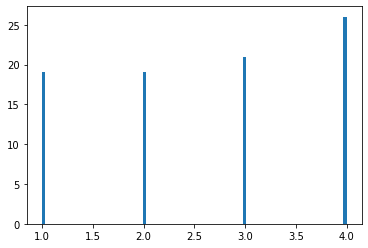

In [49]:
plt.hist(best_weights, bins = 100)
plt.show()

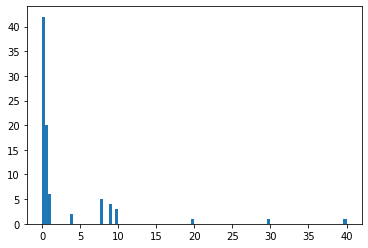

In [50]:
plt.hist(best_scales, bins = 100)
plt.show()

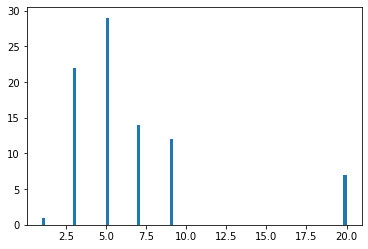

In [51]:
plt.hist(best_emas, bins = 100)
plt.show()

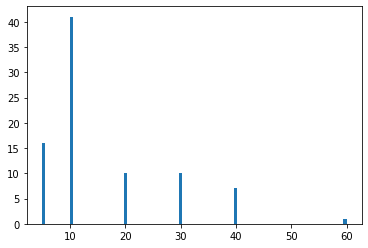

In [52]:
plt.hist(best_windows, bins = 100)
plt.show()

## 10 days

In [53]:
days10.loc['(0, 0, 0, 0, 0)']



Cumulative Return               0.022347
Cumulative Long Return               NaN
Cumulative Short Return              NaN
Maximum Drawdown               -0.018394
Average Size                         NaN
Standard Deviation              0.018483
Average Daily Return             0.00218
Number of Stocks on Last Day         NaN
Alpha                                0.0
Beta                                 1.0
Name: (0, 0, 0, 0, 0), dtype: object

In [93]:
sorted100b = sorted100.index
b10 = days10.loc[sorted100b]
b10_sorted = b10.sort_values("Cumulative Return", ascending=False)
b10_sorted = b10_sorted[b10_sorted["Cumulative Return"] > 0.03]
#b10_sorted = b10_sorted[b10_sorted["Maximum Drawdown"] > -0.03]
#b10_sorted = b10_sorted[b10_sorted["Average Size"] > 0.2]
#b10_sorted = b10_sorted[b10_sorted["Average Size"] < 50]
b10_sorted = b10_sorted[b10_sorted["Number of Stocks on Last Day"] > 1]

b10_sorted

,Cumulative Return,Cumulative Long Return,Cumulative Short Return,Maximum Drawdown,Average Size,Standard Deviation,Average Daily Return,Number of Stocks on Last Day,Alpha,Beta
Parameters,,,,,,,,,,
"(1, 0, 0.005, 10, 9, 1, 1)",0.049623,0.049623,NaN,-0.022583,3.0,0.020423,0.005601,7.0,0.0,0.0
"(2, 0, 0.01, 10, 5, 1, 1)",0.047119,0.047119,NaN,-0.036929,3.2,0.025179,0.005444,5.0,0.0,0.0
"(1, 0, 8, 10, 5)",0.039257,0.039257,NaN,-0.036871,2.3,0.023092,0.004555,4.0,0.0,0.0
"(2, 0, 4, 5, 5)",0.032319,0.032319,NaN,-0.027291,11.7,0.028252,0.003927,4.0,0.0,0.0
"(4, 0, 0.03, 10, 5, 1, 1)",0.030296,0.030296,NaN,-0.032677,4.1,0.020813,0.003538,7.0,0.0,0.0


In [94]:
returns100 = sorted100.loc[b10_sorted.index].sort_values("Yearly Sharpe", ascending=False)
#returns100 = sorted100.loc[b10_sorted.index].sort_values("Cumulative Return", ascending=False)
#returns100 = sorted100.loc[b10_sorted.index].sort_values("Alpha", ascending=False)

returns100

,Cumulative Return,Cumulative Long Return,Cumulative Short Return,Maximum Drawdown,Average Size,10 Day Average Size,Standard Deviation,Average Daily Return,Number of Stocks on Last Day,Alpha,Beta,Daily Sharpe,Yearly Sharpe
Parameters,,,,,,,,,,,,,
"(2, 0, 4, 5, 5)",0.943615,0.943615,NaN,-0.047342,17.35,11.7,0.020778,0.006949,4.0,0.511544,0.004764,0.334420,5.287639
"(1, 0, 0.005, 10, 9, 1, 1)",0.892462,0.892462,NaN,-0.069012,11.80,3.0,0.019969,0.006664,7.0,0.534278,0.004382,0.333721,5.276592
"(4, 0, 0.03, 10, 5, 1, 1)",0.963489,0.963489,NaN,-0.062598,16.35,4.1,0.021985,0.007078,7.0,0.648093,0.004310,0.321957,5.090589
"(2, 0, 0.01, 10, 5, 1, 1)",0.924649,0.924649,NaN,-0.068195,13.82,3.2,0.022145,0.006879,5.0,0.605374,0.004294,0.310657,4.911924
"(1, 0, 8, 10, 5)",0.920836,0.920836,NaN,-0.065732,12.56,2.3,0.023375,0.006886,4.0,0.633790,0.004179,0.294575,4.657634


In [95]:
best_weights = []
best_scales = []
best_windows = []
best_emas = []

for pam_set in b10_sorted.index:
    pam_set = pam_set[1:-1]
    pam_set = pam_set.replace(" ", "")
    pam_set = pam_set.split(",")
    best_weights.append(float(pam_set[0]))
    best_scales.append(float(pam_set[2]))
    best_windows.append(float(pam_set[3]))
    best_emas.append(float(pam_set[4]))

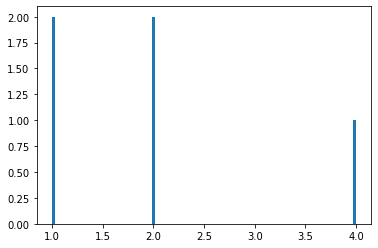

In [96]:
plt.hist(best_weights, bins = 100)
plt.show()

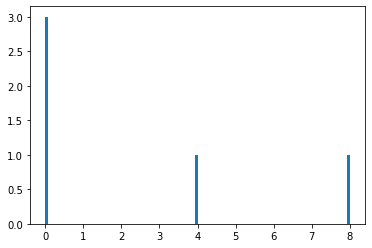

In [97]:
plt.hist(best_scales, bins = 100)
plt.show()

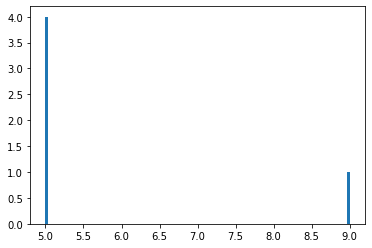

In [98]:
plt.hist(best_emas, bins = 100)
plt.show()

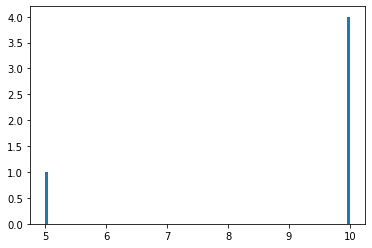

In [99]:
plt.hist(best_windows, bins = 100)
plt.show()

In [100]:
ranking = 0
filename = get_filename(b10_sorted.index[ranking], 100, dir_pre)[0]
filename, b10_sorted.index[ranking]

('s3://icosa-sagemaker-data/backtests/weight_1_disc/longs_100_day_param_test_w_1_ar_0_c1_0.005_cs1_1_win_l_10_win_s_8_es_l_9_es_s_2_c2_1_v_norm_1.csv',
 '(1, 0, 0.005, 10, 9, 1, 1)')

In [101]:
# #ranking = 0
filename = get_filename('(3, 0, 1, 60, 5, 1, 1)', 100, dir_pre)[0]
filename

#jan 3: (1, 0, 0.01, 5, -1, 1, 1) cov norm
#jan 4: (3, 0, 1, 60, 5, 1, 1) cov norm

's3://icosa-sagemaker-data/backtests/weight_3_disc/longs_100_day_param_test_w_3_ar_0_c1_1_cs1_1_win_l_60_win_s_8_es_l_5_es_s_2_c2_1_v_norm_1.csv'

In [143]:
ranking = 3
filename = get_filename(returns100.index[ranking], 100, dir_pre)[0]
filename

's3://icosa-sagemaker-data/backtests/weight_2_disc/longs_100_day_param_test_w_2_ar_0_c1_0.01_cs1_1_win_l_10_win_s_8_es_l_5_es_s_2_c2_1_v_norm_1.csv'

In [144]:
# get backtest with the given ranking (0 would be the backtest with the best results)
if len(b10_sorted):
    best_longs=pd.read_csv(filename, index_col="Dates")
best_longs

,Stocks,Number of Stocks,Energy,Execution Time,Portfolio Value,Daily Return,Cumulative Return,Daily Long Return,Cumulative Long Return,Daily Short Return,Cumulative Short Return
Dates,,,,,,,,,,,
2022-09-07,"{'long AEFES.IS': 379.38, 'long ALARK.IS': 378...",34,-0.124604,3.000057,10583.535239,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-08,"{'long AEFES.IS': 248.88, 'long ALARK.IS': 267...",43,-0.192953,4.910202,10650.585889,0.006335,0.006335,0.006335,0.006335,NaN,NaN
2022-09-09,"{'long AEFES.IS': 205.82, 'long AGHOL.IS': 161...",49,-0.174270,5.578027,10743.675099,0.008740,0.015131,0.008740,0.015131,NaN,NaN
2022-09-12,"{'long AEFES.IS': 249.94, 'long AKSA.IS': 225....",46,-0.243774,5.758693,10986.125304,0.022567,0.038039,0.022567,0.038039,NaN,NaN
2022-09-13,"{'long AEFES.IS': 1369.94, 'long ALARK.IS': 42...",11,-0.036302,8.004014,10576.858669,-0.037253,-0.000631,-0.037253,-0.000631,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-01-24,"{'long ASUZU.IS': 10275.0, 'long TUPRS.IS': 99...",2,-0.001836,3.360861,20742.393768,-0.018800,0.959874,-0.018800,0.959874,NaN,NaN
2023-01-25,"{'long BIOEN.IS': 2486.77, 'long PGSUS.IS': 73...",4,-0.007031,1.978458,19976.393768,-0.036929,0.887497,-0.036929,0.887497,NaN,NaN
2023-01-26,"{'long BIOEN.IS': 3595.57, 'long FENER.IS': 35...",7,-0.026461,2.195728,20435.853768,0.023000,0.930910,0.023000,0.930910,NaN,NaN


In [145]:
np.nanmax(best_longs["Daily Return"])

0.0796154407068063

In [146]:
np.nanmin(best_longs["Daily Return"])

-0.0681945029490374

In [147]:
best_longs.iloc[-2]["Stocks"]

"{'long ALARK.IS': 6626.25, 'long FENER.IS': 6632.799999999999, 'long PGSUS.IS': 1893.3999999999996, 'long SELEC.IS': 2208.0, 'long TUPRS.IS': 1874.9, 'cash_l': 839.6676488996491, 'cash_s': 0, 'cash_rem': 0.0}"

In [148]:
best_longs.iloc[-1][0]

"{'long FENER.IS': 4021.749999999999, 'long FROTO.IS': 3712.7999999999997, 'long MAVI.IS': 4063.5, 'long SELEC.IS': 4060.88, 'long TTRAK.IS': 4043.9000000000005, 'cash_l': 453.9136514027996, 'cash_s': 0, 'cash_rem': 0.0}"

In [149]:
long_bench_cum = get_cum_bench(dir_pre, best_longs)

In [150]:
best_longs.tail(30)

,Stocks,Number of Stocks,Energy,Execution Time,Portfolio Value,Daily Return,Cumulative Return,Daily Long Return,Cumulative Long Return,Daily Short Return,Cumulative Short Return
Dates,,,,,,,,,,,
2022-12-20,"{'long AEFES.IS': 3275.9, 'long BIOEN.IS': 328...",8,-3.220470e-02,2.087682,19812.747981,0.002491,0.872035,0.002491,0.872035,NaN,NaN
2022-12-21,"{'long ALGYO.IS': 1865.3, 'long BIOEN.IS': 190...",15,-9.111370e-02,2.562692,19842.649530,0.001509,0.874860,0.001509,0.874860,NaN,NaN
2022-12-22,"{'long BIOEN.IS': 1980.3100000000002, 'long EN...",14,-6.873034e-02,5.073514,19818.705154,-0.001207,0.872598,-0.001207,0.872598,NaN,NaN
2022-12-23,"{'long CIMSA.IS': 2316.1, 'long ENKAI.IS': 239...",10,-5.689577e-02,2.331641,20034.116945,0.010869,0.892951,0.010869,0.892951,NaN,NaN
2022-12-26,"{'long AEFES.IS': 894.4, 'long AKFGY.IS': 309....",25,-1.066312e-01,3.935164,20530.274820,0.024766,0.939831,0.024766,0.939831,NaN,NaN
2022-12-27,"{'long ASUZU.IS': 1708.0, 'long ERBOS.IS': 169...",13,-3.449193e-02,3.683963,20252.908192,-0.013510,0.913624,-0.013510,0.913624,NaN,NaN
2022-12-28,"{'long DOAS.IS': 2397.2000000000003, 'long KCH...",4,-1.833419e-02,2.662977,19637.319732,-0.030395,0.855459,-0.030395,0.855459,NaN,NaN
2022-12-29,"{'long BUCIM.IS': 2856.71, 'long DOAS.IS': 904...",9,-7.055379e-02,3.521739,20035.061573,0.020254,0.893041,0.020254,0.893041,NaN,NaN
2022-12-30,"{'long BUCIM.IS': 928.51, 'long DOAS.IS': 904....",10,-8.664649e-02,3.213408,20427.821278,0.019604,0.930151,0.019604,0.930151,NaN,NaN


In [151]:
full_bench_100.pct_change().tail(5)

Date
2023-01-24   -0.007013
2023-01-25   -0.012802
2023-01-26   -0.012609
2023-01-27   -0.007494
2023-01-30   -0.018394
Name: Close, dtype: float64

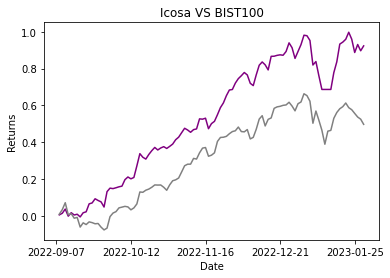

This set of parameters generated a cumulative return of 92.3435146372964% while the benchmark generated a cumulative return of 49.767830362015886%


In [152]:
draw_plot(best_longs, long_bench_cum, dir_pre)

In [153]:
# how the best set of parameters performed since october 14th
long_bench_cum_p = get_cum_bench(dir_pre, adjust_cumulative(best_longs.loc["2022-10-19":], 0))

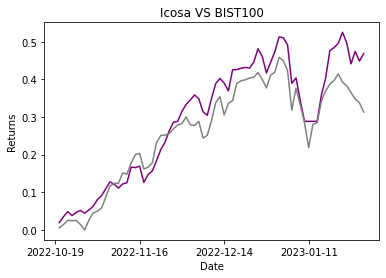

This set of parameters generated a cumulative return of 46.923913655004654% while the benchmark generated a cumulative return of 31.337776474956225%


In [154]:
draw_plot(adjust_cumulative(best_longs.loc["2022-10-19":], 0), long_bench_cum_p, dir_pre)

In [155]:
# how the best set of parameters performed since october 14th
long_bench_cum_p = get_cum_bench(dir_pre, adjust_cumulative(best_longs.loc["2023-01-02":"2023-01-16"], 0))

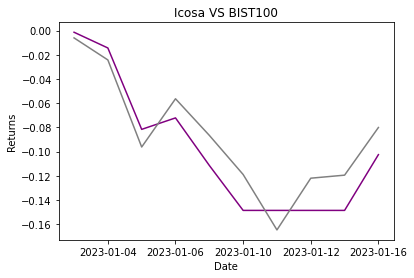

This set of parameters generated a cumulative return of -10.250709849530704% while the benchmark generated a cumulative return of -8.0090423154938%


In [156]:
draw_plot(adjust_cumulative(best_longs.loc["2023-01-02":"2023-01-16"], 0), long_bench_cum_p, dir_pre)

In [118]:
best_longs.loc["2023-01-02":"2023-01-16"]

,Stocks,Number of Stocks,Energy,Execution Time,Portfolio Value,Daily Return,Cumulative Return,Daily Long Return,Cumulative Long Return,Daily Short Return,Cumulative Short Return
Dates,,,,,,,,,,,
2023-01-02,"{'long ENJSA.IS': 2104.48, 'long KCHOL.IS': 63...",4,-3.655978e-03,2.539812,21354.522740,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-03,"{'long ASELS.IS': 4233.400000000001, 'long BRY...",7,-5.582839e-03,3.009639,21382.445925,0.001308,0.001308,0.001308,0.001308,NaN,NaN
2023-01-04,"{'long AEFES.IS': 1733.7499999999998, 'long GU...",5,-4.341465e-03,3.228223,20894.903749,-0.022801,-0.021523,-0.022801,-0.021523,NaN,NaN
2023-01-05,"{'long GUBRF.IS': 19891.6, 'cash_l': 14.093748...",1,-1.344514e-04,3.783464,19905.693749,-0.047342,-0.067846,-0.047342,-0.067846,NaN,NaN
2023-01-06,"{'long GUBRF.IS': 9831.0, 'long TUPRS.IS': 967...",2,-2.931503e-04,3.342838,20041.056798,0.006800,-0.061508,0.006800,-0.061508,NaN,NaN
2023-01-09,"{'cash_l': 0, 'cash_s': 0, 'cash_rem': 19610.4...",0,-2.913225e-13,3.485466,19610.431519,-0.021487,-0.081673,-0.021487,-0.081673,NaN,NaN
2023-01-10,"{'cash_l': 0, 'cash_s': 0, 'cash_rem': 19610.4...",0,0.000000e+00,3.400517,19610.431519,0.000000,-0.081673,0.000000,-0.081673,0.0,NaN
2023-01-11,"{'cash_l': 0, 'cash_s': 0, 'cash_rem': 19610.4...",0,0.000000e+00,3.507239,19610.431519,0.000000,-0.081673,0.000000,-0.081673,0.0,NaN
2023-01-12,"{'long KLRHO.IS': 9781.8, 'long SASA.IS': 9700...",2,-1.467787e-03,4.050015,19610.431519,0.000000,-0.081673,0.000000,-0.081673,0.0,NaN


## alpha analysis

In [119]:
port_ret = best_longs["Daily Return"].loc["2022-10-17":]
port_ret

Dates
2022-10-17    0.049203
2022-10-18   -0.029134
2022-10-19         NaN
2022-10-20    0.006453
2022-10-21    0.012368
                ...   
2023-01-24   -0.027291
2023-01-25   -0.013259
2023-01-26    0.011613
2023-01-27   -0.020018
2023-01-30    0.002914
Name: Daily Return, Length: 76, dtype: float64

In [120]:
mkt_pct = full_bench_100.pct_change()
mkt_ret = mkt_pct.loc["2022-10-17":]
mkt_ret

Date
2022-10-17    0.060822
2022-10-18   -0.001559
2022-10-19    0.010074
2022-10-20    0.005309
2022-10-21    0.008639
                ...   
2023-01-24   -0.007013
2023-01-25   -0.012802
2023-01-26   -0.012609
2023-01-27   -0.007494
2023-01-30   -0.018394
Name: Close, Length: 76, dtype: float64

In [121]:
len(port_ret) == len(mkt_ret)

True

In [122]:
port_beta, port_alpha = np.polyfit(mkt_ret, port_ret, 1)
print(port_beta, port_alpha)

nan nan


In [123]:
port_ret_mean = port_ret.mean()
mkt_ret_mean = mkt_ret.mean()
port_alpha = port_ret_mean - (port_beta * (mkt_ret_mean))
port_alpha

nan

## SHORTS

In [124]:
days10_short

,Cumulative Return,Cumulative Long Return,Cumulative Short Return,Maximum Drawdown,Maximum Short Drawdown,Average Size,Average Short Size,Standard Deviation,Average Daily Return,Number of Stocks on Last Day,Alpha,Beta
Parameters,,,,,,,,,,,,
"(1, 1, 0.005, 10, -1, 1, 1)",0.024763,NaN,0.024763,-0.005988,-0.005988,1.1,1.1,0.010131,0.002772,6.0,-0.005957,0.002745
"(1, 1, 0.005, 10, 1, 1, 1)",0.076465,NaN,0.076465,-0.008090,-0.008090,1.5,1.5,0.019082,0.008398,5.0,-0.298073,0.007030
"(1, 1, 0.005, 10, 3, 1, 1)",0.040049,NaN,0.040049,-0.014712,-0.014712,2.1,2.1,0.015041,0.004484,8.0,-0.192370,0.003600
"(1, 1, 0.005, 10, 5, 1, 1)",0.054174,NaN,0.054174,-0.009886,-0.009886,2.5,2.5,0.014653,0.005984,10.0,-0.285120,0.004675
"(1, 1, 0.005, 10, 7, 1, 1)",0.059416,NaN,0.059416,-0.010056,-0.010056,2.8,2.8,0.014921,0.006543,11.0,-0.273686,0.005286
...,...,...,...,...,...,...,...,...,...,...,...,...
"(4, 1, 9, 5, -1)",0.069572,NaN,0.069572,-0.020273,-0.020273,8.3,8.3,0.015799,0.007625,28.0,-0.224066,0.006596
"(4, 1, 9, 5, 1)",0.064188,NaN,0.064188,-0.012431,-0.012431,7.7,7.7,0.015828,0.007060,24.0,-0.503672,0.004748
"(4, 1, 9, 5, 3)",0.069314,NaN,0.069314,-0.021204,-0.021204,8.7,8.7,0.016179,0.007604,27.0,-0.242595,0.006490


In [125]:
sorted100s = days100_short.sort_values("Cumulative Return", ascending=False)
sorted100s = sorted100s[days100_short["Number of Stocks on Last Day"] > 1]
sorted100s = sorted100s[sorted100s["Cumulative Return"] > 0.15]
sorted100s

/tmp/ipykernel_3912/3008135764.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sorted100s = sorted100s[days100_short["Number of Stocks on Last Day"] > 1]


,Cumulative Return,Cumulative Long Return,Cumulative Short Return,Maximum Drawdown,Maximum Short Drawdown,Average Size,Average Short Size,10 Day Average Size,10 Day Average Short Size,Standard Deviation,Average Daily Return,Number of Stocks on Last Day,Alpha,Beta
Parameters,,,,,,,,,,,,,,
"(1, 1, 9, 30, 7)",0.584759,NaN,0.584759,-0.049546,-0.049546,0.84,0.84,0.6,0.6,0.027183,0.005022,2.0,-0.601737,0.007592
"(4, 1, 9, 30, 7)",0.534944,NaN,0.534944,-0.049900,-0.049900,0.84,0.84,0.6,0.6,0.027029,0.004694,2.0,-0.595016,0.007235
"(2, 1, 9, 30, 7)",0.534944,NaN,0.534944,-0.049900,-0.049900,0.84,0.84,0.6,0.6,0.027029,0.004694,2.0,-0.595016,0.007235
"(3, 1, 9, 30, 7)",0.534944,NaN,0.534944,-0.049900,-0.049900,0.84,0.84,0.6,0.6,0.027029,0.004694,2.0,-0.595016,0.007235
"(1, 1, 8, 10, 9)",0.491063,NaN,0.491063,-0.046911,-0.046911,3.49,3.49,2.9,2.9,0.024717,0.004346,9.0,-0.726030,0.007447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(2, 1, 10, 15, 3)",0.153632,NaN,0.153632,-0.056605,-0.056605,0.91,0.91,0.7,0.7,0.025918,0.001773,2.0,-0.615118,0.004401
"(3, 1, 40, 20, 5)",0.152986,NaN,0.152986,-0.063067,-0.063067,3.40,3.40,3.0,3.0,0.028256,0.001832,5.0,-0.881089,0.005596
"(4, 1, 40, 30, 9)",0.152981,NaN,0.152981,-0.062976,-0.062976,3.86,3.86,2.8,2.8,0.029170,0.001860,6.0,-0.862093,0.005542


In [141]:
s10 = days10_short.loc[sorted100s.index]
s10_sorted = s10.sort_values("Cumulative Return", ascending=False)
s10_sorted = s10_sorted[s10_sorted["Average Short Size"] > 0]
#s10_sorted = s10_sorted[s10_sorted["Maximum Drawdown"] > maximum_drawdown_short]
s10_sorted = s10_sorted[s10_sorted["Cumulative Short Return"] > 0.09]
s10_sorted = s10_sorted[s10_sorted["Number of Stocks on Last Day"] > 0]
s10_sorted

,Cumulative Return,Cumulative Long Return,Cumulative Short Return,Maximum Drawdown,Maximum Short Drawdown,Average Size,Average Short Size,Standard Deviation,Average Daily Return,Number of Stocks on Last Day,Alpha,Beta
Parameters,,,,,,,,,,,,
"(1, 1, 20, 30, 5)",0.125874,NaN,0.125874,-0.009250,-0.009250,2.3,2.3,0.018662,0.013431,3.0,-0.694687,0.010242
"(4, 1, 20, 30, 5)",0.125792,NaN,0.125792,-0.009251,-0.009251,2.3,2.3,0.018642,0.013423,3.0,-0.694822,0.010232
"(2, 1, 20, 30, 5)",0.125792,NaN,0.125792,-0.009251,-0.009251,2.3,2.3,0.018642,0.013423,3.0,-0.694822,0.010232
"(3, 1, 20, 30, 5)",0.125792,NaN,0.125792,-0.009251,-0.009251,2.3,2.3,0.018642,0.013423,3.0,-0.694822,0.010232
"(3, 1, 30, 40, 5)",0.113756,NaN,0.113756,-0.009805,-0.009805,2.6,2.6,0.018182,0.012205,3.0,-0.600292,0.009449
...,...,...,...,...,...,...,...,...,...,...,...,...
"(3, 1, 40, 40, 5)",0.091758,NaN,0.091758,-0.013137,-0.013137,2.8,2.8,0.017354,0.009950,3.0,-0.518310,0.007571
"(4, 1, 40, 40, 5)",0.091758,NaN,0.091758,-0.013137,-0.013137,2.8,2.8,0.017354,0.009950,3.0,-0.518310,0.007571
"(2, 1, 9, 40, 20)",0.091534,NaN,0.091534,-0.015684,-0.015684,1.0,1.0,0.023323,0.010043,2.0,-0.197218,0.009137


In [142]:
sorted100s_b = sorted100s.loc[s10_sorted.index]
sorted100s_b = sorted100s_b.sort_values("Cumulative Return", ascending=False)
sorted100s_b

,Cumulative Return,Cumulative Long Return,Cumulative Short Return,Maximum Drawdown,Maximum Short Drawdown,Average Size,Average Short Size,10 Day Average Size,10 Day Average Short Size,Standard Deviation,Average Daily Return,Number of Stocks on Last Day,Alpha,Beta
Parameters,,,,,,,,,,,,,,
"(1, 1, 8, 10, 9)",0.491063,NaN,0.491063,-0.046911,-0.046911,3.49,3.49,2.9,2.9,0.024717,0.004346,9.0,-0.726030,0.007447
"(2, 1, 30, 30, 5)",0.393456,NaN,0.393456,-0.064335,-0.064335,2.22,2.22,2.5,2.5,0.032962,0.003892,3.0,-0.889191,0.007690
"(2, 1, 40, 20, 3)",0.386114,NaN,0.386114,-0.062952,-0.062952,2.51,2.51,2.6,2.6,0.031773,0.003801,4.0,-0.921048,0.007735
"(3, 1, 8, 10, 9)",0.381242,NaN,0.381242,-0.062626,-0.062626,3.16,3.16,2.5,2.5,0.024240,0.003560,7.0,-0.694094,0.006524
"(4, 1, 8, 10, 9)",0.377596,NaN,0.377596,-0.062607,-0.062607,3.16,3.16,2.5,2.5,0.024056,0.003528,7.0,-0.670198,0.006391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(1, 1, 10, 10, 5)",0.156679,NaN,0.156679,-0.051839,-0.051839,2.65,2.65,2.6,2.6,0.025873,0.001802,9.0,-0.731719,0.004927
"(4, 1, 10, 15, 9)",0.154058,NaN,0.154058,-0.081676,-0.081676,2.44,2.44,1.1,1.1,0.026970,0.001809,2.0,-0.712991,0.004854
"(3, 1, 10, 15, 9)",0.154058,NaN,0.154058,-0.081676,-0.081676,2.44,2.44,1.1,1.1,0.026970,0.001809,2.0,-0.712991,0.004854


In [128]:
# get backtest with the given ranking (0 would be the backtest with the best results)
best_ranking = 0
if len(s10_sorted):
    best_shorts=pd.read_csv(get_filename(sorted100s_b.index[best_ranking], 100, dir_pre)[0], index_col="Dates")
    print(get_filename(sorted100s_b.index[0], 100, dir_pre)[0])
best_shorts

s3://icosa-sagemaker-data/backtests/weight_1_disc/shorts_100_day_param_test_w_1_ar_1_c1_5_cs1_8_win_l_0_win_s_10_es_l_3_es_s_9.csv


,Stocks,Number of Stocks,Energy,Execution Time,Portfolio Value,Daily Return,Cumulative Return,Daily Long Return,Cumulative Long Return,Daily Short Return,Cumulative Short Return
Dates,,,,,,,,,,,
2022-09-07,"{'short AKSA.IS': 1185.45, 'short BERA.IS': 12...",7,-0.005111,0.550759,9785.868324,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-08,"{'short AKSA.IS': 1352.85, 'short HEKTS.IS': 1...",6,-0.004936,0.560432,9758.718986,-0.002774,-0.002774,NaN,NaN,-0.002774,-0.002774
2022-09-09,"{'short OYAKC.IS': 9680.9, 'cash_l': 0, 'cash_...",1,-0.000044,0.555684,9685.736455,-0.007479,-0.010232,NaN,NaN,-0.007479,-0.010232
2022-09-12,"{'short ALARK.IS': 4569.599999999999, 'short M...",2,-0.000579,0.514209,9242.288778,-0.045784,-0.055547,NaN,NaN,-0.045784,-0.055547
2022-09-13,"{'short AKSA.IS': 1036.45, 'short ALARK.IS': 1...",8,-0.011661,0.477258,9472.588778,0.024918,-0.032013,NaN,NaN,0.024918,-0.032013
...,...,...,...,...,...,...,...,...,...,...,...
2023-01-24,"{'short EKGYO.IS': 6715.68, 'short ODAS.IS': 6...",2,-0.001542,0.794309,13444.117994,0.034440,0.373830,NaN,NaN,0.034440,0.373830
2023-01-25,"{'short AGHOL.IS': 2247.6000000000004, 'short ...",6,-0.007632,0.419397,13780.677994,0.025034,0.408222,NaN,NaN,0.025034,0.408222
2023-01-26,"{'short AKBNK.IS': 4544.64, 'short ALARK.IS': ...",3,-0.002158,0.617132,13654.784232,-0.009136,0.395357,NaN,NaN,-0.009136,0.395357


In [129]:
get_filename(s10_sorted.index[best_ranking], 100, dir_pre)[0]

's3://icosa-sagemaker-data/backtests/weight_1_disc/shorts_100_day_param_test_w_1_ar_1_c1_5_cs1_20_win_l_0_win_s_30_es_l_3_es_s_5.csv'

In [130]:
best_shorts.iloc[-1]['Stocks']

"{'short AKSA.IS': 1541.0, 'short ALARK.IS': 1508.85, 'short BIMAS.IS': 1546.8000000000002, 'short DOHOL.IS': 1564.62, 'short ODAS.IS': 1566.08, 'short PGSUS.IS': 1551.6000000000001, 'short THYAO.IS': 1453.0, 'short TKFEN.IS': 1564.5200000000002, 'short VAKBN.IS': 1559.91, 'cash_l': 0, 'cash_s': 267.84483259920125, 'cash_rem': -1.8189894035458565e-12}"

In [131]:
# get backtest with the given ranking (0 would be the backtest with the best results)
best_ranking = 0
if len(s10_sorted):
    best_shorts=pd.read_csv(get_filename(s10_sorted.index[best_ranking], 100, dir_pre)[0], index_col="Dates")
    print(get_filename(sorted100s_b.index[0], 100, dir_pre)[0])
best_shorts

s3://icosa-sagemaker-data/backtests/weight_1_disc/shorts_100_day_param_test_w_1_ar_1_c1_5_cs1_8_win_l_0_win_s_10_es_l_3_es_s_9.csv


,Stocks,Number of Stocks,Energy,Execution Time,Portfolio Value,Daily Return,Cumulative Return,Daily Long Return,Cumulative Long Return,Daily Short Return,Cumulative Short Return
Dates,,,,,,,,,,,
2022-09-07,"{'cash_l': 0, 'cash_s': 0, 'cash_rem': 9362.37...",0,-6.106227e-16,0.482466,9362.370192,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-08,"{'short AKSA.IS': 4631.4, 'short AKSEN.IS': 46...",2,-2.971882e-04,0.370628,9362.370192,0.000000,0.000000,0.0,0.0,0.000000,0.000000
2022-09-09,"{'short AKSEN.IS': 9308.02, 'cash_l': 0, 'cash...",1,-1.828694e-04,0.558414,9331.540192,-0.003293,-0.003293,NaN,NaN,-0.003293,-0.003293
2022-09-12,"{'cash_l': 0, 'cash_s': 0, 'cash_rem': 9168.92...",0,0.000000e+00,0.550379,9168.926285,-0.017426,-0.020662,NaN,NaN,-0.017426,-0.020662
2022-09-13,"{'short AKSA.IS': 2291.1, 'short AKSEN.IS': 22...",4,-2.524659e-03,0.490297,9168.926285,0.000000,-0.020662,0.0,NaN,0.000000,-0.020662
...,...,...,...,...,...,...,...,...,...,...,...
2023-01-24,"{'short AEFES.IS': 4900.9, 'short ODAS.IS': 49...",2,-1.378236e-03,0.513520,9857.948260,0.020272,0.052933,NaN,NaN,0.020272,0.052933
2023-01-25,"{'short AEFES.IS': 3359.5, 'short BERA.IS': 33...",3,-6.646607e-03,0.724349,10183.924361,0.033067,0.087751,NaN,NaN,0.033067,0.087751
2023-01-26,"{'short AEFES.IS': 3359.5, 'short BERA.IS': 33...",3,-4.045538e-03,0.592662,10089.727649,-0.009250,0.077689,NaN,NaN,-0.009250,0.077689


In [132]:
get_filename(s10_sorted.index[best_ranking], 100, dir_pre)

['s3://icosa-sagemaker-data/backtests/weight_1_disc/shorts_100_day_param_test_w_1_ar_1_c1_5_cs1_20_win_l_0_win_s_30_es_l_3_es_s_5.csv']

In [133]:
s10_sorted.index[best_ranking]

'(1, 1, 20, 30, 5)'

In [134]:
for port in best_shorts["Stocks"]:
    print(port)

{'cash_l': 0, 'cash_s': 0, 'cash_rem': 9362.370191561304}
{'short AKSA.IS': 4631.4, 'short AKSEN.IS': 4671.58, 'cash_l': 0, 'cash_s': 59.390191561304164, 'cash_rem': 0.0}
{'short AKSEN.IS': 9308.02, 'cash_l': 0, 'cash_s': 23.520191561301544, 'cash_rem': 0.0}
{'cash_l': 0, 'cash_s': 0, 'cash_rem': 9168.926285202113}
{'short AKSA.IS': 2291.1, 'short AKSEN.IS': 2271.4, 'short KORDS.IS': 2274.7, 'short SASA.IS': 2288.0, 'cash_l': 0, 'cash_s': 43.726285202112194, 'cash_rem': 0.0}
{'short AKSA.IS': 2899.3999999999996, 'short EGEEN.IS': 2322.2, 'short ISGYO.IS': 2915.25, 'cash_l': 0, 'cash_s': 658.1562852021116, 'cash_rem': 0.0}
{'short EGEEN.IS': 2322.2, 'short OYAKC.IS': 2913.0499999999997, 'cash_l': 0, 'cash_s': 617.218943429958, 'cash_rem': 0.0, 'short ISGYO.IS': 2624.57}
{'short AKBNK.IS': 5692.73, 'cash_l': 0, 'cash_s': 1.3005965594393274, 'cash_rem': 0.0, 'short ISGYO.IS': 2886.05852398524}
{'short AKBNK.IS': 3126.8099999999995, 'short ISGYO.IS': 3116.7585239852397, 'short TUPRS.IS': 3

In [135]:
cur_counter = 0
cur_best = 0
counter = 0
for x in best_shorts["Daily Return"]:
    counter+=1
    if x > cur_best:
        cur_best = x
        cur_counter = counter


In [136]:
cur_counter

13

In [137]:
cur_best

0.0993073012964474

In [138]:
best_shorts.iloc[41]["Stocks"]

"{'short ISCTR.IS': 10804.08, 'cash_l': 0, 'cash_s': 3.0563895656541717, 'cash_rem': 0.0}"

In [139]:
short_bench_cum = get_cum_bench(dir_pre, best_shorts)

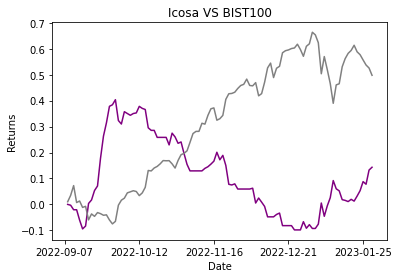

This set of parameters generated a cumulative return of 14.320816755254958% while the benchmark generated a cumulative return of 49.767830362015886%


In [140]:
draw_plot(best_shorts, short_bench_cum, dir_pre)

In [113]:
best_shorts.loc["2022-09-23"]["Stocks"]

"{'short EGEEN.IS': 2333.1, 'short ISGYO.IS': 3936.989191408634, 'short TKFEN.IS': 1296.0, 'short TSKB.IS': 1310.1299999999997, 'short TUPRS.IS': 1229.6, 'cash_l': 0, 'cash_s': 1706.5828308530072, 'cash_rem': 1.8189894035458565e-12}"

In [114]:
# how the best set of parameters performed since october 14th
short_bench_cum_p = get_cum_bench(dir_pre, adjust_cumulative(best_shorts.loc["2022-10-14":], 0))

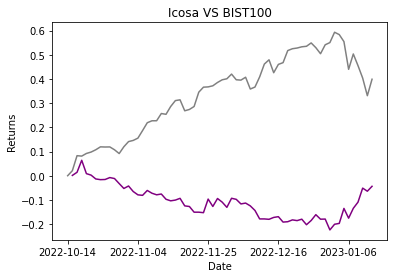

This set of parameters generated a cumulative return of -4.377444790477492% while the benchmark generated a cumulative return of 39.885752572738234%


In [115]:
draw_plot(adjust_cumulative(best_shorts.loc["2022-10-14":], 0), short_bench_cum_p, dir_pre)

In [116]:
# days with positive returns since october 14th
pos_d = 0
for d in best_shorts.loc["2022-10-14":]["Daily Return"]:
    if d>0:
        pos_d+=1
pos_d/(len(best_shorts.loc["2022-10-14":])), pos_d

(0.4393939393939394, 29)

## Result Analysis

In [73]:
np.mean(days100["Cumulative Return"])

1.0651706638929708

In [74]:
min(days100["Maximum Drawdown"].values)

-0.0999484801648634

In [75]:
max(days100["Maximum Drawdown"].values)

-0.039259356126477

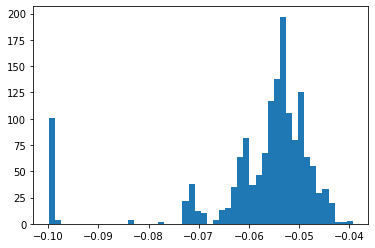

In [76]:
plt.hist(days100["Maximum Drawdown"].values, bins=50)
plt.show()

## Appendix (functions used to fix issues with .csv files in the past)

In [1149]:
def fix_file(file_name):
    v_test=pd.read_csv(file_name, index_col="Dates")
    for ind in v_test.index:
        if v_test.loc[ind,"Daily Short Return"]==-1:
            v_test.at[ind, "Daily Short Return"]=0
            v_test.at[ind, "Daily Long Return"]=v_test.at[ind, "Daily Return"]

        if v_test.loc[ind,"Daily Long Return"]==-1:
            v_test.at[ind, "Daily Long Return"]=0
            v_test.at[ind, "Daily Short Return"]=v_test.at[ind, "Daily Return"]
        
    l_cum=1
    s_cum=1
    for r in range(1, len(v_test)):
        l_cum*= (1+v_test.iloc[r, 7])
        v_test.iat[r,8]=(l_cum-1)

        s_cum*= (1+v_test.iloc[r, 9])
        v_test.iat[r,10]=(s_cum-1)
    return v_test

In [1680]:
def indexing_fixer(file_name, close_name):
    gen_cum = 0
    df = pd.read_csv(file_name, index_col="Dates")
    reformatted_index = dict()
    for ind in list(df.index):
        if ind==list(df.index)[0]:
            reformatted_index[ind] = str(dt.datetime.strptime(ind, '%Y-%m-%d')-BDay(1)).split()[0]
        else:
            reformatted_index[ind] = list(df.index)[df.index.get_loc(ind)-1]
    df = df.rename(reformatted_index, axis=0)
    closes = pd.read_csv(close_name, index_col="Date").loc[df.index[0]:]
    pct_changes = pd.read_csv(close_name, index_col="Date").pct_change()
    prev_ar = ast.literal_eval(get_key(file_name))[1]/10
    df.loc[df.index[0], "Portfolio Value"] = sum(ast.literal_eval(df.loc[df.index[0], "Stocks"]).values())
    for d in df.index[1:]:
        # get day before current day
        prev_d = df.index[df.index.get_loc(d)-1]
        
        # get yesterday's portfolio
        prev_port = ast.literal_eval(df.loc[prev_d, "Stocks"])
        
        # compute gains if yesterday's portfolio was nonempty
        if len(prev_port):
            long_size, short_size, p_size = 0, 0, 0
            long_prev, short_prev = False, False

            for s in prev_port:
                action, stock = s.split()

                sign = 1
                if action == "short":
                    sign = -1
                    short_prev = True
                else:
                    long_prev = True
                gains = prev_port[s]*(1+sign*pct_changes[stock][d])

                p_size += gains
                long_size += gains*int(action=="long")
                short_size += gains*int(action=="short")
        else:
            p_size = df.loc[prev_d, "Portfolio Value"]
            
        # compute overall cumulative return
        if len(prev_port):
            prev_total_cap = sum(ast.literal_eval(df.loc[prev_d, "Stocks"]).values())
        else:
            prev_total_cap = df.loc[prev_d, "Portfolio Value"]
        daily_return = (p_size - prev_total_cap)/prev_total_cap
        gen_cum = (gen_cum+1)*(daily_return+1)-1
        
        
        # computing daily and cumulative returns for the long/short portions of the portofolio
        if len(prev_port):
            long_factor, long_factor_denom = (1-prev_ar), (1-prev_ar)
            short_factor, short_factor_denom = prev_ar, prev_ar

            if not short_prev:
                long_factor, short_factor = 1, 0
                short_factor_denom = 1

            if not long_prev:
                short_factor, long_factor = 1, 0
                long_factor_denom = 1
            daily_long = (long_size-(prev_total_cap)*long_factor)/(prev_total_cap*long_factor_denom)
            daily_short = (short_size-(prev_total_cap)*short_factor)/(prev_total_cap*short_factor_denom)
            prev_long_cum = df.loc[prev_d, "Cumulative Long Return"]

            if np.isnan(prev_long_cum):
                cur_long_cum = daily_long
            else:
                cur_long_cum = ((1+prev_long_cum)*(1+daily_long)) - 1

            prev_short_cum = df.loc[prev_d, "Cumulative Short Return"]
            if np.isnan(prev_short_cum):
                cur_short_cum = daily_short
            else:
                cur_short_cum = ((1+prev_short_cum)*(1+daily_short)) - 1
        else:
            daily_long, daily_short = 0, 0
            cur_long_cum, cur_short_cum = df.loc[prev_d, "Cumulative Long Return"], df.loc[prev_d, "Cumulative Short Return"]
        
        # adjusting existing position sizes using the actual capital available
        fix_factor = p_size/sum(ast.literal_eval(df.loc[d, "Stocks"]).values())
        old_cur_port = ast.literal_eval(df.loc[d, "Stocks"])
        for old_p in old_cur_port:
            old_cur_port[old_p] = old_cur_port[old_p]*fix_factor
        
        # rewriting fixed values
        df.at[d, "Stocks"] = str(old_cur_port)
        if len(old_cur_port):
            df.at[d, "Portfolio Value"] = sum(old_cur_port.values())
        else:
            df.at[d, "Portfolio Value"] = df.loc[prev_d, "Portfolio Value"]
        
        
        df.at[d, "Daily Return"] = daily_return
        df.at[d, "Cumulative Return"] = gen_cum
        
        df.at[d, "Daily Long Return"] = daily_long
        df.at[d, "Cumulative Long Return"] = cur_long_cum
        
        df.at[d, "Daily Short Return"] = daily_short
        df.at[d, "Cumulative Short Return"] = cur_short_cum
    
    return df

In [1684]:
"""
for f in os.listdir("weight_4_bd/"):
    if len(f.split("_"))==25:
        new_df = indexing_fixer("weight_4_bd/" + f, "../hist_price_data.csv")
        new_df.to_csv("w4_test_fix/" + f)
        w_val = ast.literal_eval(get_key("weight_4_bd/" + f))[0]
        ar = ast.literal_eval(get_key("weight_4_bd/" + f))[1]
        c = ast.literal_eval(get_key("weight_4_bd/" + f))[2]
        win = ast.literal_eval(get_key("weight_4_bd/" + f))[3]
        es = ast.literal_eval(get_key("weight_4_bd/" + f))[4]
        

        results_name = "w4_test_fix/"+f.split("_")[0]+"_"+f.split("_")[1]+"_day_results.csv"

        if os.path.exists(results_name):
            df_r = pd.read_csv(results_name, index_col="Parameters")
            if ar:
                df_r.loc[str((w_val, ar, c, win, es))]=(new_df.iloc[-1, 6], new_df.iloc[-1, 8], new_df.iloc[-1, 10], np.nanmin(new_df.iloc[:, 5]), np.nanmean(new_df.iloc[:, 1]))
            else:
                df_r.loc[str((w_val, ar, c, win, es))]=(new_df.iloc[-1, 6], np.nan, np.nan, np.nanmin(new_df.iloc[:, 5]), np.nanmean(new_df.iloc[:, 1]))
            df_r.to_csv(results_name)
        else:
            df_r = pd.DataFrame(columns=["Parameters", "Cumulative Return", "Cumulative Long Return", "Cumulative Short Return", "Maximum Drawdown", "Average Size"])
            df_r = df_r.set_index("Parameters")
            if ar:
                df_r.loc[str((w_val, ar, c, win, es))]=(new_df.iloc[-1, 6], new_df.iloc[-1, 8], new_df.iloc[-1, 10], np.nanmin(new_df.iloc[:, 5]), np.nanmean(new_df.iloc[:, 1]))
            else:
                df_r.loc[str((w_val, ar, c, win, es))]=(new_df.iloc[-1, 6], np.nan, np.nan, np.nanmin(new_df.iloc[:, 5]), np.nanmean(new_df.iloc[:, 1]))
            df_r.to_csv(results_name)
"""

In [850]:
"""
counter = 0
total = 0
for i in range(1, 6):
    cur_dirct = "weight_" + str(i) + "/"
    for fs in os.listdir(cur_dirct):
        if len(fs.split("_"))>20:
            temps = pd.read_csv(cur_dirct + fs, index_col="Dates")
            if "win_l_0" in fs:
                if "2022-11-29" in temps.index:
                    temps = temps.loc[:"2022-11-29"]
                    temps.to_csv(cur_dirct+fs)
counter
"""

0

In [975]:
"""
counter = 0
total = 0
for i in range(1, 6):
    cur_dirct = "weight_" + str(i) + "/"
    for fs in os.listdir(cur_dirct):
        if len(fs.split("_"))>20:
            temps = pd.read_csv(cur_dirct + fs, index_col="Dates")
            if "2022-12-02" in temps.index:
                total+=1
                if np.isnan(temps.loc["2022-12-02", "Cumulative Long Return"]) or np.isnan(temps.loc["2022-12-01", "Cumulative Long Return"]) or np.isnan(temps.loc["2022-11-30", "Cumulative Long Return"]):
                    counter+=1
"""

In [201]:
#grid_params = pd.read_csv(f_b_pref+"grid_params.csv", index_col="Parameter Names")
grid_params

NameError: name 'grid_params' is not defined

In [1297]:
"""
weight_range = [1, 2, 3, 4, 5]
scales_arr = ast.literal_eval(grid_params.loc["return scales", "Parameters"])
es_arr = ast.literal_eval(grid_params.loc["ema smoothing", "Parameters"])
windows_arr = ast.literal_eval(grid_params.loc["windows", "Parameters"])
cov_scales = ast.literal_eval(grid_params.loc["covariance scales", "Parameters"])
vol_norms = ast.literal_eval(grid_params.loc["volatility normalization", "Parameters"])
roof_tolerance = ast.literal_eval(grid_params.loc["rf tolerance", "Parameters"])
"""

In [1307]:
"""
for cov_f in cov_scales:
    for v_norm in vol_norms:
        for w_val in weight_range:
            for ar in range(1):
                for c in scales_arr:
                    for win in windows_arr:
                        for es in es_arr:
                            #print("cur_params: " + str([w_val, ar, c, win, es]))
                            if cov_f!=1 or v_norm:
                                filename_100 = "weight_"+str(w_val)+"/longs_100_day_param_test_w_" + str(w_val) + "_ar_" + str(ar) + "_c1_"+ str(c) +"_cs1_1_win_l_"+ str(win) +"_win_s_8_es_l_"+ str(es) +"_es_s_2_c2_"+ str(cov_f) +"_v_norm_"+str((1 if v_norm else 0))+".csv"
                            else:
                                filename_100 = "weight_"+str(w_val)+"/longs_100_day_param_test_w_" + str(w_val) + "_ar_" + str(ar) + "_c1_"+ str(c) +"_cs1_1_win_l_"+ str(win) +"_win_s_8_es_l_"+ str(es) +"_es_s_2.csv"

                            if os.path.exists(filename_100):
                                temp=pd.read_csv(filename_100, index_col="Dates")
                                #print(temp.columns)
                                for r in range(len(temp)):
                                    cur_day = temp.index[r]
                                    temp.at[cur_day, "Daily Long Return"] = temp.loc[cur_day, "Daily Return"]
                                    temp.at[cur_day, "Cumulative Long Return"] = temp.loc[cur_day, "Cumulative Return"]
                                temp.to_csv(filename_100)
"""

In [1310]:
weight_range = [1, 2, 3, 4, 5]
scales_arr = ast.literal_eval(grid_params.loc["return scales", "Parameters"])
es_arr = ast.literal_eval(grid_params.loc["ema smoothing", "Parameters"])
windows_arr = ast.literal_eval(grid_params.loc["windows", "Parameters"])
cov_scales = ast.literal_eval(grid_params.loc["covariance scales", "Parameters"])
vol_norms = ast.literal_eval(grid_params.loc["volatility normalization", "Parameters"])
roof_tolerance = ast.literal_eval(grid_params.loc["rf tolerance", "Parameters"])

In [1311]:
"""
for cov_f in cov_scales:
    for v_norm in vol_norms:
        for w_val in weight_range:
            for ar in range(1,2):
                for c_s in scales_arr:
                    for win_s in windows_arr:
                        for es_s in es_arr:
                            print("cur_params: " + str([w_val, ar, c_s, win_s, es_s]))
                            
                            if cov_f!=1 or v_norm:
                                filename_100 = "weight_"+str(w_val)+"/shorts_100_day_param_test_w_" + str(w_val) + "_ar_" + str(ar) + "_c1_5_cs1_" + str(c_s) + "_win_l_0_win_s_" + str(win_s) + "_es_l_3_es_s_" + str(es_s) + "_cs2_"+ str(cov_f) +"_v_norm_"+str((1 if v_norm else 0))+".csv"
                            else:
                                filename_100 = "weight_"+str(w_val)+"/shorts_100_day_param_test_w_" + str(w_val) + "_ar_" + str(ar) + "_c1_5_cs1_" + str(c_s) + "_win_l_0_win_s_" + str(win_s) + "_es_l_3_es_s_" + str(es_s) + ".csv"
                            
                            if os.path.exists(filename_100):
                                temp=pd.read_csv(filename_100, index_col="Dates")
                                #print(temp.columns)
                                for r in range(len(temp)):
                                    cur_day = temp.index[r]
                                    temp.at[cur_day, "Daily Short Return"] = temp.loc[cur_day, "Daily Return"]
                                    temp.at[cur_day, "Cumulative Short Return"] = temp.loc[cur_day, "Cumulative Return"]
                                temp.to_csv(filename_100)
"""

cur_params: [1, 1, 3, 11, 3]
cur_params: [1, 1, 3, 11, 5]
cur_params: [1, 1, 3, 11, 7]
cur_params: [1, 1, 3, 11, 10]
cur_params: [1, 1, 3, 11, 20]
cur_params: [1, 1, 3, 11, 33]
cur_params: [1, 1, 3, 12, 3]
cur_params: [1, 1, 3, 12, 5]
cur_params: [1, 1, 3, 12, 7]
cur_params: [1, 1, 3, 12, 10]
cur_params: [1, 1, 3, 12, 20]
cur_params: [1, 1, 3, 12, 33]
cur_params: [1, 1, 3, 13, 3]
cur_params: [1, 1, 3, 13, 5]
cur_params: [1, 1, 3, 13, 7]
cur_params: [1, 1, 3, 13, 10]
cur_params: [1, 1, 3, 13, 20]
cur_params: [1, 1, 3, 13, 33]
cur_params: [1, 1, 3, 33, 3]
cur_params: [1, 1, 3, 33, 5]
cur_params: [1, 1, 3, 33, 7]
cur_params: [1, 1, 3, 33, 10]
cur_params: [1, 1, 3, 33, 20]
cur_params: [1, 1, 3, 33, 33]
cur_params: [1, 1, 4, 11, 3]
cur_params: [1, 1, 4, 11, 5]
cur_params: [1, 1, 4, 11, 7]
cur_params: [1, 1, 4, 11, 10]
cur_params: [1, 1, 4, 11, 20]
cur_params: [1, 1, 4, 11, 33]
cur_params: [1, 1, 4, 12, 3]
cur_params: [1, 1, 4, 12, 5]
cur_params: [1, 1, 4, 12, 7]
cur_params: [1, 1, 4, 12, 10

In [1706]:
n_indexes = []
indexes = []
for pind in days100.index:
    if ast.literal_eval(pind)[-1] > ast.literal_eval(pind)[-2]:
        if np.isnan(days100.loc[pind, "Cumulative Long Return"]):
            n_indexes.append(pind)
        else:
            indexes.append(pind)

In [1710]:
n_ratios = [ast.literal_eval(p)[-1]/ast.literal_eval(p)[-2] for p in n_indexes]
ratios = [ast.literal_eval(p2)[-1]/ast.literal_eval(p2)[-2] for p2 in indexes]

In [1806]:
w_indexes = []
for pind in days100.index:
    if ast.literal_eval(pind)[-1]/ast.literal_eval(pind)[-2] > 2:
        if not np.isnan(days100.loc[pind, "Cumulative Long Return"]):
            w_indexes.append(pind)

In [1808]:
w_indexes

['(1, 0, 4, 12, 33)',
 '(1, 0, 5, 11, 33)',
 '(1, 0, 3, 11, 33)',
 '(1, 0, 5, 13, 33)',
 '(1, 0, 9, 13, 33)',
 '(1, 0, 4, 11, 33)',
 '(1, 0, 9, 12, 33)',
 '(1, 0, 11, 13, 33)',
 '(1, 0, 11, 12, 33)',
 '(1, 0, 20, 11, 33)',
 '(1, 0, 3, 13, 33)',
 '(1, 0, 3, 12, 33)',
 '(1, 0, 9, 11, 33)',
 '(1, 0, 11, 11, 33)',
 '(1, 0, 33, 12, 33)',
 '(1, 0, 20, 13, 33)',
 '(1, 0, 33, 11, 33)',
 '(1, 0, 5, 12, 33)',
 '(1, 0, 4, 13, 33)',
 '(1, 0, 10, 12, 33)',
 '(1, 0, 10, 11, 33)',
 '(1, 0, 10, 13, 33)',
 '(1, 0, 33, 13, 33)',
 '(1, 0, 20, 12, 33)',
 '(2, 0, 20, 12, 33)',
 '(2, 0, 4, 11, 33)',
 '(2, 0, 5, 13, 33)',
 '(2, 0, 33, 12, 33)',
 '(2, 0, 4, 12, 33)',
 '(2, 0, 5, 12, 33)',
 '(2, 0, 11, 11, 33)',
 '(2, 0, 33, 11, 33)',
 '(2, 0, 3, 12, 33)',
 '(2, 0, 9, 13, 33)',
 '(2, 0, 3, 11, 33)',
 '(2, 0, 20, 11, 33)',
 '(2, 0, 10, 12, 33)',
 '(2, 0, 20, 13, 33)',
 '(2, 0, 11, 13, 33)',
 '(2, 0, 9, 12, 33)',
 '(2, 0, 3, 13, 33)',
 '(2, 0, 4, 13, 33)',
 '(2, 0, 5, 11, 33)',
 '(2, 0, 11, 12, 33)',
 '(2, 0, 10

In [1794]:
np.median(n_ratios)

2.75

In [1803]:
gt = [1 if r==1 else 0 for r in ratios]
sum(gt)/len(ratios)

0.0

In [1713]:
np.mean(n_ratios)

2.7628205128205128

In [1714]:
np.mean(ratios)

2.100132842068326

In [1791]:
#sanity check for ema issue
num_neg = 0
samp_size = 10000
for _ in range(samp_size):
    p = 100
    e = 100
    s = 2.0
    for i in range(50):
        p *=random.randrange(90, 110)/100
        e = p*s + (1-s)*e
    if e < 0:
        num_neg += 1
num_neg/samp_size

0.1412

In [ ]:
"""
hekts=pd.read_excel("hekts.xlsx", header=None)
hekts = hekts.loc[5826:]
hekts=hekts.set_index(0)
hekts = hekts.rename(index={h:h.split()[0].replace(".", "-") for h in hekts.index})
hekts = hekts.rename(index={h:h.split("-")[2] + "-" + h.split("-")[1] + "-" + h.split("-")[0] for h in hekts.index})
for r in t_grid.index[:-2]:
    t_grid.at[r, "HEKTS.IS"] = float(hekts.loc[r, 4].replace(",", "."))
"""

In [38]:
#datafromgrid=pd.read_csv(f_b_pref+"grid_search_data/t_grid.csv", index_col="Date")

In [39]:
#datafromgrid.to_csv("basic_price_data.csv")

In [581]:
last_day_perfs = []
for t in days100.index:
    if ast.literal_eval(t)[-1] > 10:
        print(t)
        temp_p=pd.read_csv(get_filename(t, 100, dir_pre)[0], index_col="Dates")
        last_day_perfs.append(temp_p["Daily Return"][-1])

(1, 0, 10, 40, 11)
(1, 0, 4, 40, 11)
(1, 0, 6, 40, 11)
(1, 0, 11, 20, 11)
(1, 0, 10, 35, 11)
(1, 0, 6, 35, 11)
(1, 0, 6, 15, 11)
(1, 0, 11, 15, 11)
(1, 0, 12, 30, 11)
(1, 0, 4, 30, 11)
(1, 0, 4, 20, 11)
(1, 0, 5, 15, 11)
(1, 0, 12, 40, 11)
(1, 0, 12, 15, 11)
(1, 0, 6, 30, 11)
(1, 0, 6, 20, 11)
(1, 0, 11, 30, 11)
(1, 0, 10, 15, 11)
(1, 0, 4, 35, 11)
(1, 0, 10, 30, 11)
(1, 0, 12, 35, 11)
(1, 0, 4, 15, 11)
(1, 0, 10, 20, 11)
(1, 0, 5, 30, 11)
(1, 0, 5, 40, 11)
(1, 0, 11, 35, 11)
(1, 0, 5, 20, 11)
(1, 0, 11, 40, 11)
(1, 0, 5, 35, 11)
(1, 0, 12, 20, 11)
(2, 0, 5, 30, 11)
(2, 0, 4, 35, 11)
(2, 0, 4, 15, 11)
(2, 0, 4, 20, 11)
(2, 0, 4, 40, 11)
(2, 0, 5, 20, 11)
(2, 0, 5, 40, 11)
(2, 0, 5, 15, 11)
(2, 0, 5, 35, 11)
(2, 0, 4, 30, 11)
(3, 0, 4, 15, 11)
(3, 0, 4, 20, 11)
(3, 0, 4, 40, 11)
(3, 0, 4, 30, 11)
(3, 0, 5, 30, 11)
(3, 0, 4, 35, 11)
(3, 0, 5, 20, 11)
(3, 0, 5, 15, 11)
(4, 0, 4, 15, 11)
(4, 0, 4, 40, 11)
(4, 0, 4, 20, 11)
(4, 0, 4, 30, 11)
(4, 0, 4, 35, 11)


In [582]:
np.mean(last_day_perfs), np.median(last_day_perfs), np.nanmin(last_day_perfs), np.nanmax(last_day_perfs), np.std(last_day_perfs)

(-0.013455206941101052,
 -0.0129885863334387,
 -0.0340322274450122,
 0.0030718444365101,
 0.008233551088393343)

In [569]:
"likely range of outcomes: ", "low end: ", np.mean(last_day_perfs)-np.std(last_day_perfs), "high end: ", np.mean(last_day_perfs)+np.std(last_day_perfs), 

('likely range of outcomes: ',
 'low end: ',
 -0.02819108539155657,
 'high end: ',
 0.0046070653844994865)

In [570]:
pd.read_csv(get_filename("(2, 0, 9, 33, 7)", 100, dir_pre)[0], index_col="Dates")["Daily Return"][-1]

IndexError: list index out of range

In [571]:
get_filename("(2, 0, 9, 33, 7)", 100, dir_pre)[0]

IndexError: list index out of range

In [ ]:
"longs_"+str(period)+"_day_param_test_w_"+str(weight)+"_ar_"+str(ar)+"_c1_"+str(factor)+"_cs1_.*_win_l_"+str(window)+"_win_s_.*_es_l_"+str(smoothing)+"_es_s_.*\.csv")

In [197]:
sorted100 = sorted100[sorted100["Cumulative Return"] > 1.33]
sorted100 = sorted100[sorted100["Cumulative Return"] < 1.34]
sorted100

,Cumulative Return,Cumulative Long Return,Cumulative Short Return,Maximum Drawdown,Average Size,10 Day Average Size,Standard Deviation,Average Daily Return,Daily Sharpe,Yearly Sharpe
Parameters,,,,,,,,,,
"(4, 0, 8, 35, 10)",1.337967,1.337967,0.0,-0.056488,9.24,5.2,0.021166,0.008838,0.417552,6.602073
"(3, 0, 8, 35, 10)",1.337967,1.337967,0.0,-0.056488,9.24,5.2,0.021166,0.008838,0.417552,6.602073
"(3, 0, 9, 45, 10)",1.337492,1.337492,0.0,-0.044701,8.31,5.8,0.020437,0.008821,0.431630,6.824663
"(2, 0, 9, 45, 10)",1.337272,1.337272,0.0,-0.044701,8.29,5.8,0.020402,0.008820,0.432290,6.835098
"(2, 0, 8, 15, 9)",1.336748,1.336748,0.0,-0.043279,16.11,5.8,0.019225,0.008794,0.457409,7.232269
"(4, 0, 9, 33, 10)",1.335273,1.335273,0.0,-0.054728,11.04,6.1,0.020682,0.008817,0.426319,6.740700
"(3, 0, 10, 40, 10)",1.334814,1.334814,0.0,-0.050075,10.03,6.8,0.020610,0.008813,0.427610,6.761107
"(4, 0, 10, 40, 10)",1.334814,1.334814,0.0,-0.050075,10.03,6.8,0.020610,0.008813,0.427610,6.761107
"(4, 0, 9, 45, 10)",1.334286,1.334286,0.0,-0.044701,8.51,5.8,0.020362,0.008806,0.432453,6.837676


In [199]:
pd.read_csv(get_filename("(4, 0, 8, 35, 10)", 100, "")[0], index_col="Dates")

,Stocks,Number of Stocks,Energy,Execution Time,Portfolio Value,Daily Return,Cumulative Return,Daily Long Return,Cumulative Long Return,Daily Short Return,Cumulative Short Return
Dates,,,,,,,,,,,
2022-08-08,"{'long AGHOL.IS': 698.2213952565269, 'long AKF...",18,-0.095892,6.012136,10240.580464,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-09,"{'long AKFGY.IS': 313.09315079544183, 'long AY...",17,-0.032090,16.346103,9788.002805,-0.021200,-0.021200,-0.021200,-0.021200,0.0,0.0
2022-08-10,"{'long AEFES.IS': 591.2458887324, 'long AGHOL....",17,-0.018762,11.304544,9815.049200,0.002763,-0.018495,0.002763,-0.018495,0.0,0.0
2022-08-11,"{'long ALBRK.IS': 729.4149959583158, 'long AYD...",14,-0.018727,6.936040,9971.905381,0.015981,-0.002809,0.015981,-0.002809,0.0,0.0
2022-08-12,"{'long AGHOL.IS': 733.9065812878885, 'long ALB...",12,-0.013204,6.120456,10033.310294,0.006158,0.003331,0.006158,0.003331,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-20,"{'long ARCLK.IS': 4854.883653222139, 'long FRO...",5,-0.004116,6.207036,23704.142897,-0.027377,1.370414,-0.027377,1.370414,0.0,0.0
2022-12-21,"{'long FROTO.IS': 6035.04309290651, 'long GSDH...",4,-0.003023,6.476876,23573.050822,-0.005530,1.357305,-0.005530,1.357305,0.0,0.0
2022-12-22,"{'long ENJSA.IS': 5961.306698977516, 'long GUB...",4,-0.002753,5.783524,23285.034359,-0.012218,1.328503,-0.012218,1.328503,0.0,0.0


In [200]:
pd.read_csv(get_filename("(3, 0, 8, 35, 10)", 100, "")[0], index_col="Dates")

,Stocks,Number of Stocks,Energy,Execution Time,Portfolio Value,Daily Return,Cumulative Return,Daily Long Return,Cumulative Long Return,Daily Short Return,Cumulative Short Return
Dates,,,,,,,,,,,
2022-08-08,"{'long AGHOL.IS': 698.2213952565269, 'long AKF...",18,-0.095892,7.958059,10240.580464,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-09,"{'long AKFGY.IS': 313.09315079544183, 'long AY...",17,-0.032090,21.846606,9788.002805,-0.021200,-0.021200,-0.021200,-0.021200,0.0,0.0
2022-08-10,"{'long AEFES.IS': 591.2458887324, 'long AGHOL....",17,-0.018762,14.401668,9815.049200,0.002763,-0.018495,0.002763,-0.018495,0.0,0.0
2022-08-11,"{'long ALBRK.IS': 729.4149959583158, 'long AYD...",14,-0.018727,8.948934,9971.905381,0.015981,-0.002809,0.015981,-0.002809,0.0,0.0
2022-08-12,"{'long AGHOL.IS': 733.9065812878885, 'long ALB...",12,-0.013204,7.756848,10033.310294,0.006158,0.003331,0.006158,0.003331,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-20,"{'long ARCLK.IS': 4854.883653222139, 'long FRO...",5,-0.004116,7.456894,23704.142897,-0.027377,1.370414,-0.027377,1.370414,0.0,0.0
2022-12-21,"{'long FROTO.IS': 6035.04309290651, 'long GSDH...",4,-0.003023,8.057353,23573.050822,-0.005530,1.357305,-0.005530,1.357305,0.0,0.0
2022-12-22,"{'long ENJSA.IS': 5961.306698977516, 'long GUB...",4,-0.002753,6.987233,23285.034359,-0.012218,1.328503,-0.012218,1.328503,0.0,0.0


In [201]:
pd.read_csv(get_filename("(3, 0, 9, 45, 10)", 100, "")[0], index_col="Dates")

,Stocks,Number of Stocks,Energy,Execution Time,Portfolio Value,Daily Return,Cumulative Return,Daily Long Return,Cumulative Long Return,Daily Short Return,Cumulative Short Return
Dates,,,,,,,,,,,
2022-08-08,"{'long AGHOL.IS': 1129.6381151524022, 'long BE...",14,-0.073233,8.351054,10429.248793,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-09,"{'long AEFES.IS': 523.3654681002142, 'long AGH...",15,-0.028687,12.271445,9736.243191,-0.026376,-0.026376,-0.026376,-0.026376,0.0,0.0
2022-08-10,"{'long AEFES.IS': 857.393871554855, 'long AGHO...",10,-0.019835,11.601876,9865.261308,0.013251,-0.013474,0.013251,-0.013474,0.0,0.0
2022-08-11,"{'long BIMAS.IS': 802.6382051051228, 'long GEN...",11,-0.018701,6.648986,10004.840112,0.014149,0.000484,0.014149,0.000484,0.0,0.0
2022-08-12,"{'long AGHOL.IS': 1162.4085507672485, 'long AL...",9,-0.012571,6.163504,10031.093480,0.002624,0.003109,0.002624,0.003109,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-20,"{'long ARCLK.IS': 4864.383412896658, 'long FRO...",5,-0.004715,3.564556,23320.871472,-0.009308,1.332087,-0.009308,1.332087,0.0,0.0
2022-12-21,"{'long ARCLK.IS': 4865.408570856081, 'long FRO...",5,-0.003577,3.691108,23325.786293,0.000211,1.332579,0.000211,1.332579,0.0,0.0
2022-12-22,"{'long ENJSA.IS': 4803.355406346299, 'long GUB...",5,-0.003139,3.451256,23028.290444,-0.012754,1.302829,-0.012754,1.302829,0.0,0.0


In [202]:
pd.read_csv(get_filename("(2, 0, 9, 45, 10)", 100, "")[0], index_col="Dates")

,Stocks,Number of Stocks,Energy,Execution Time,Portfolio Value,Daily Return,Cumulative Return,Daily Long Return,Cumulative Long Return,Daily Short Return,Cumulative Short Return
Dates,,,,,,,,,,,
2022-08-08,"{'long AGHOL.IS': 1170.7181817085777, 'long BE...",13,-0.073233,4.023508,10536.463635,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-09,"{'long AEFES.IS': 542.3980131023454, 'long AGH...",14,-0.028687,6.171357,9754.934257,-0.024507,-0.024507,-0.024507,-0.024507,0.0,0.0
2022-08-10,"{'long AEFES.IS': 866.1265035670431, 'long AGH...",10,-0.019835,6.533272,9864.332477,0.011215,-0.013567,0.011215,-0.013567,0.0,0.0
2022-08-11,"{'long BIMAS.IS': 810.8131458373153, 'long GEN...",11,-0.018701,4.051992,10003.898139,0.014149,0.000390,0.014149,0.000390,0.0,0.0
2022-08-12,"{'long AGHOL.IS': 1174.2477841212994, 'long AL...",9,-0.012571,3.613006,10030.149036,0.002624,0.003015,0.002624,0.003015,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-20,"{'long ARCLK.IS': 4913.927585907811, 'long FRO...",5,-0.004715,3.208763,23318.675772,-0.009308,1.331868,-0.009308,1.331868,0.0,0.0
2022-12-21,"{'long ARCLK.IS': 4914.963185191239, 'long FRO...",5,-0.003577,3.884738,23323.590131,0.000211,1.332359,0.000211,1.332359,0.0,0.0
2022-12-22,"{'long ENJSA.IS': 4852.278003741713, 'long GUB...",5,-0.003139,3.512889,23026.122291,-0.012754,1.302612,-0.012754,1.302612,0.0,0.0


In [203]:
pd.read_csv(get_filename("(2, 0, 8, 15, 9)", 100, "")[0], index_col="Dates")

,Stocks,Number of Stocks,Energy,Execution Time,Portfolio Value,Daily Return,Cumulative Return,Daily Long Return,Cumulative Long Return,Daily Short Return,Cumulative Short Return
Dates,,,,,,,,,,,
2022-08-08,"{'long AKFGY.IS': 267.60219570622195, 'long AK...",45,-0.193299,8.463907,10135.705725,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-09,"{'long AEFES.IS': 124.94975793759889, 'long AK...",34,-0.073142,12.037597,9983.203360,-0.001680,-0.001680,-0.001680,-0.001680,0.0,0.0
2022-08-10,"{'long AEFES.IS': 149.97251204723804, 'long AK...",32,-0.048070,7.459771,10061.589292,0.007852,0.006159,0.007852,0.006159,0.0,0.0
2022-08-11,"{'long AKSEN.IS': 134.40811538277248, 'long AL...",35,-0.052330,4.784851,10210.857700,0.014835,0.021086,0.014835,0.021086,0.0,0.0
2022-08-12,"{'long AEFES.IS': 134.04333931980122, 'long AK...",36,-0.050705,5.847916,10315.394656,0.010238,0.031539,0.010238,0.031539,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-20,"{'long ARCLK.IS': 5781.644144033146, 'long FRO...",4,-0.005392,4.208811,22816.937669,-0.024712,1.281694,-0.024712,1.281694,0.0,0.0
2022-12-21,"{'long HEKTS.IS': 3246.746824753011, 'long NTH...",5,-0.007353,6.882697,22422.935698,-0.017268,1.242294,-0.017268,1.242294,0.0,0.0
2022-12-22,"{'long ENJSA.IS': 5666.6159033089225, 'long GU...",4,-0.005945,4.379288,22362.985102,-0.002674,1.236299,-0.002674,1.236299,0.0,0.0


In [204]:
pd.read_csv(get_filename("(4, 0, 9, 33, 10)", 100, "")[0], index_col="Dates")

,Stocks,Number of Stocks,Energy,Execution Time,Portfolio Value,Daily Return,Cumulative Return,Daily Long Return,Cumulative Long Return,Daily Short Return,Cumulative Short Return
Dates,,,,,,,,,,,
2022-08-05,"{'long AGHOL.IS': 909.0909090909091, 'long ALG...",11,-0.005123,12.192586,10000.000000,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-08,"{'long AGHOL.IS': 816.6537683799976, 'long AKF...",20,-0.273267,6.586381,10033.174869,0.003317,0.003317,0.003317,0.003317,0.0,0.0
2022-08-09,"{'long AEFES.IS': 235.47460724289692, 'long AG...",22,-0.080958,16.280790,9790.843392,-0.024153,-0.020916,-0.024153,-0.020916,0.0,0.0
2022-08-10,"{'long AEFES.IS': 428.94480299709994, 'long AG...",17,-0.040279,11.961670,9865.730469,0.007649,-0.013427,0.007649,-0.013427,0.0,0.0
2022-08-11,"{'long AGHOL.IS': 457.27265928679844, 'long AL...",18,-0.031652,6.614620,10059.998504,0.019691,0.006000,0.019691,0.006000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-20,"{'long ARCLK.IS': 3882.9714479700997, 'long FR...",6,-0.005965,6.463545,23297.828688,-0.022831,1.329783,-0.022831,1.329783,0.0,0.0
2022-12-21,"{'long GSDHO.IS': 4622.7613949539955, 'long IS...",5,-0.004280,10.742751,23113.806975,-0.007899,1.311381,-0.007899,1.311381,0.0,0.0
2022-12-22,"{'long ENJSA.IS': 5737.652371804556, 'long GUB...",4,-0.003780,6.146688,22950.609487,-0.007061,1.295061,-0.007061,1.295061,0.0,0.0


In [205]:
pd.read_csv(get_filename("(3, 0, 10, 40, 10)", 100, "")[0], index_col="Dates")

,Stocks,Number of Stocks,Energy,Execution Time,Portfolio Value,Daily Return,Cumulative Return,Daily Long Return,Cumulative Long Return,Daily Short Return,Cumulative Short Return
Dates,,,,,,,,,,,
2022-08-08,"{'long AGHOL.IS': 290.0255581585681, 'long BER...",16,-0.051644,6.295827,9974.990791,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-09,"{'long AEFES.IS': 400.59676561555636, 'long AG...",19,-0.023992,8.463267,9853.092190,-0.014691,-0.014691,-0.014691,-0.014691,0.0,0.0
2022-08-10,"{'long AEFES.IS': 602.159453696587, 'long AYDE...",13,-0.017108,5.705610,9963.998064,0.011256,-0.003600,0.011256,-0.003600,0.0,0.0
2022-08-11,"{'long ALBRK.IS': 610.1770320970624, 'long AYD...",13,-0.021787,3.349677,10258.580655,0.029565,0.025858,0.029565,0.025858,0.0,0.0
2022-08-12,"{'long AGHOL.IS': 615.678770484713, 'long ALBR...",13,-0.017271,3.378272,10351.078445,0.009017,0.035108,0.009017,0.035108,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-20,"{'long ARCLK.IS': 3396.189415753388, 'long ASE...",7,-0.006230,3.523614,23511.072674,-0.026232,1.351107,-0.026232,1.351107,0.0,0.0
2022-12-21,"{'long ARCLK.IS': 4699.0644750155725, 'long FR...",5,-0.004528,3.505186,23236.135909,-0.011694,1.323614,-0.011694,1.323614,0.0,0.0
2022-12-22,"{'long ENJSA.IS': 4639.132854337949, 'long GUB...",5,-0.004677,9.160054,22939.783456,-0.012754,1.293978,-0.012754,1.293978,0.0,0.0


In [206]:
pd.read_csv(get_filename("(4, 0, 10, 40, 10)", 100, "")[0], index_col="Dates")

,Stocks,Number of Stocks,Energy,Execution Time,Portfolio Value,Daily Return,Cumulative Return,Daily Long Return,Cumulative Long Return,Daily Short Return,Cumulative Short Return
Dates,,,,,,,,,,,
2022-08-08,"{'long AGHOL.IS': 290.0255581585681, 'long BER...",16,-0.051644,11.123110,9974.990791,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-09,"{'long AEFES.IS': 400.59676561555636, 'long AG...",19,-0.023992,15.065956,9853.092190,-0.014691,-0.014691,-0.014691,-0.014691,0.0,0.0
2022-08-10,"{'long AEFES.IS': 602.159453696587, 'long AYDE...",13,-0.017108,10.186356,9963.998064,0.011256,-0.003600,0.011256,-0.003600,0.0,0.0
2022-08-11,"{'long ALBRK.IS': 610.1770320970624, 'long AYD...",13,-0.021787,5.871705,10258.580655,0.029565,0.025858,0.029565,0.025858,0.0,0.0
2022-08-12,"{'long AGHOL.IS': 615.678770484713, 'long ALBR...",13,-0.017271,5.860085,10351.078445,0.009017,0.035108,0.009017,0.035108,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-20,"{'long ARCLK.IS': 3396.189415753388, 'long ASE...",7,-0.006230,6.149453,23511.072674,-0.026232,1.351107,-0.026232,1.351107,0.0,0.0
2022-12-21,"{'long ARCLK.IS': 4699.0644750155725, 'long FR...",5,-0.004528,6.074222,23236.135909,-0.011694,1.323614,-0.011694,1.323614,0.0,0.0
2022-12-22,"{'long ENJSA.IS': 4639.132854337949, 'long GUB...",5,-0.004677,8.489701,22939.783456,-0.012754,1.293978,-0.012754,1.293978,0.0,0.0


In [222]:
# weird
pd.read_csv(get_filename("(4, 0, 9, 45, 10)", 100, "")[0], index_col="Dates")

,Stocks,Number of Stocks,Energy,Execution Time,Portfolio Value,Daily Return,Cumulative Return,Daily Long Return,Cumulative Long Return,Daily Short Return,Cumulative Short Return
Dates,,,,,,,,,,,
2022-08-05,"{'long AGHOL.IS': 3333.333333333333, 'long MAV...",3,-0.002300,6.483192,10000.000000,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-08,"{'long AGHOL.IS': 792.1101370765956, 'long BER...",13,-0.133647,6.585282,9769.358357,-0.023064,-0.023064,-0.023064,-0.023064,0.0,0.0
2022-08-09,"{'long AGHOL.IS': 390.0095501678492, 'long AKF...",18,-0.050375,16.440813,9533.665322,-0.024126,-0.046633,-0.024126,-0.046633,0.0,0.0
2022-08-10,"{'long AEFES.IS': 660.1329035691479, 'long AGH...",13,-0.032572,11.997034,9670.806262,0.014385,-0.032919,0.014385,-0.032919,0.0,0.0
2022-08-11,"{'long AGHOL.IS': 654.5556478776975, 'long BIM...",13,-0.026064,6.751617,9818.334718,0.015255,-0.018167,0.015255,-0.018167,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-20,"{'long ARCLK.IS': 4550.350133894401, 'long FRO...",5,-0.004715,6.310751,22751.750669,-0.009308,1.275175,-0.009308,1.275175,0.0,0.0
2022-12-21,"{'long ARCLK.IS': 4551.30911004039, 'long FROT...",5,-0.003577,6.113038,22756.545550,0.000211,1.275655,0.000211,1.275655,0.0,0.0
2022-12-22,"{'long ENJSA.IS': 4493.261953501076, 'long GUB...",5,-0.003139,6.246070,22466.309768,-0.012754,1.246631,-0.012754,1.246631,0.0,0.0


In [241]:
len(tmp)

101

In [216]:
tmp=pd.read_csv(get_filename("(4, 0, 9, 45, 10)", 100, "")[0], index_col="Dates")

In [243]:
adjust_cumulative(tmp.iloc[-100:], 0)

,Stocks,Number of Stocks,Energy,Execution Time,Portfolio Value,Daily Return,Cumulative Return,Daily Long Return,Cumulative Long Return,Daily Short Return,Cumulative Short Return
Dates,,,,,,,,,,,
2022-08-08,"{'long AGHOL.IS': 792.1101370765956, 'long BER...",13,-0.133647,6.585282,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-09,"{'long AGHOL.IS': 390.0095501678492, 'long AKF...",18,-0.050375,16.440813,9758.742563,-0.024126,-0.024126,-0.024126,-0.024126,0.0,0.0
2022-08-10,"{'long AEFES.IS': 660.1329035691479, 'long AGH...",13,-0.032572,11.997034,9899.121220,0.014385,-0.010088,0.014385,-0.010088,0.0,0.0
2022-08-11,"{'long AGHOL.IS': 654.5556478776975, 'long BIM...",13,-0.026064,6.751617,10050.132628,0.015255,0.005013,0.015255,0.005013,0.0,0.0
2022-08-12,"{'long AGHOL.IS': 895.8830708557504, 'long ALB...",11,-0.016149,6.473270,10087.370551,0.003705,0.008737,0.003705,0.008737,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-20,"{'long ARCLK.IS': 4550.350133894401, 'long FRO...",5,-0.004715,6.310751,23288.889441,-0.009308,1.328889,-0.009308,1.328889,0.0,0.0
2022-12-21,"{'long ARCLK.IS': 4551.30911004039, 'long FROT...",5,-0.003577,6.113038,23293.797523,0.000211,1.329380,0.000211,1.329380,0.0,0.0
2022-12-22,"{'long ENJSA.IS': 4493.261953501076, 'long GUB...",5,-0.003139,6.246070,22996.709657,-0.012754,1.299671,-0.012754,1.299671,0.0,0.0


In [235]:
adjust_cumulative(pd.read_csv(get_filename("(4, 0, 9, 45, 10)", 100, "")[0], index_col="Dates").iloc[-100:], 0)

,Stocks,Number of Stocks,Energy,Execution Time,Portfolio Value,Daily Return,Cumulative Return,Daily Long Return,Cumulative Long Return,Daily Short Return,Cumulative Short Return
Dates,,,,,,,,,,,
2022-08-09,"{'long AGHOL.IS': 390.0095501678492, 'long AKF...",18,-0.050375,16.440813,9533.665322,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-10,"{'long AEFES.IS': 660.1329035691479, 'long AGH...",13,-0.032572,11.997034,10143.849123,0.014385,0.014385,0.014385,0.014385,0.0,0.0
2022-08-11,"{'long AGHOL.IS': 654.5556478776975, 'long BIM...",13,-0.026064,6.751617,10298.593864,0.015255,0.029859,0.015255,0.029859,0.0,0.0
2022-08-12,"{'long AGHOL.IS': 895.8830708557504, 'long ALB...",11,-0.016149,6.473270,10336.752389,0.003705,0.033675,0.003705,0.033675,0.0,0.0
2022-08-15,"{'long AGHOL.IS': 503.27470248571785, 'long AL...",17,-0.016574,10.830499,10535.426734,0.019220,0.053543,0.019220,0.053543,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-21,"{'long ARCLK.IS': 4551.30911004039, 'long FROT...",5,-0.003577,6.113038,23869.671089,0.000211,1.386967,0.000211,1.386967,0.0,0.0
2022-12-22,"{'long ENJSA.IS': 4493.261953501076, 'long GUB...",5,-0.003139,6.246070,23565.238562,-0.012754,1.356524,-0.012754,1.356524,0.0,0.0
2022-12-23,"{'long DEVA.IS': 4515.781134706858, 'long GSDH...",5,-0.004118,11.246563,23683.342042,0.005012,1.368334,0.005012,1.368334,0.0,0.0


In [217]:
tmp.loc["2022-12-15"]

Stocks                     {'long ECILC.IS': 9408.002866945091, 'long HAL...
Number of Stocks                                                           5
Energy                                                             -0.006989
Execution Time                                                     11.826942
Portfolio Value                                                  21952.00669
Daily Return                                                         0.02854
Cumulative Return                                                   1.195201
Daily Long Return                                                    0.02854
Cumulative Long Return                                              1.195201
Daily Short Return                                                       0.0
Cumulative Short Return                                                  0.0
Name: 2022-12-15, dtype: object

In [ ]:
0.195201*(1+0.023272)

In [228]:
tmp.loc["2022-12-16"]

Stocks                     {'long CCOLA.IS': 3169.0799683478626, 'long EC...
Number of Stocks                                                           7
Energy                                                             -0.005856
Execution Time                                                     10.992307
Portfolio Value                                                  22462.87005
Daily Return                                                        0.023272
Cumulative Return                                                   1.246287
Daily Long Return                                                   0.023272
Cumulative Long Return                                              1.246287
Daily Short Return                                                       0.0
Cumulative Short Return                                                  0.0
Name: 2022-12-16, dtype: object

In [230]:
(22462.87005-21952.00669)/21952.00669

0.023271829642468236

In [229]:
(22462.87005-10000)/10000

1.2462870050000001

In [226]:
get_daily_ret(ast.literal_eval(tmp.loc["2022-12-15", "Stocks"]), grid_data, "2022-12-15", tmp.loc["2022-12-15", "Portfolio Value"])

(0.023271829669471653,
 0.023271829669471653,
 0,
 {'long ECILC.IS': 9588.50524753183,
  'long HALKB.IS': 3448.3902400334136,
  'long ISMEN.IS': 3082.459475917782,
  'long QUAGR.IS': 3157.2908467254065,
  'long ULKER.IS': 3186.224239912162})

In [225]:
grid_data=pd.read_csv(f_b_pref+"grid_search_data/t_grid.csv", index_col="Date")

In [219]:
sum(ast.literal_eval(tmp.loc["2022-12-15", "Stocks"]).values())

21952.006689538546

In [220]:
sum(ast.literal_eval(tmp.loc["2022-12-16", "Stocks"]).values())

22462.87005012059

In [221]:
(22462.87005012059-21952.006689538546)/21952.006689538546

0.02327182966947165

In [218]:
tmp.loc["2022-12-16"]

Stocks                     {'long CCOLA.IS': 3169.0799683478626, 'long EC...
Number of Stocks                                                           7
Energy                                                             -0.005856
Execution Time                                                     10.992307
Portfolio Value                                                  22462.87005
Daily Return                                                        0.023272
Cumulative Return                                                   1.246287
Daily Long Return                                                   0.023272
Cumulative Long Return                                              1.246287
Daily Short Return                                                       0.0
Cumulative Short Return                                                  0.0
Name: 2022-12-16, dtype: object

In [227]:
tmp

,Stocks,Number of Stocks,Energy,Execution Time,Portfolio Value,Daily Return,Cumulative Return,Daily Long Return,Cumulative Long Return,Daily Short Return,Cumulative Short Return
Dates,,,,,,,,,,,
2022-08-05,"{'long AGHOL.IS': 3333.333333333333, 'long MAV...",3,-0.002300,6.483192,10000.000000,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-08,"{'long AGHOL.IS': 792.1101370765956, 'long BER...",13,-0.133647,6.585282,9769.358357,-0.023064,-0.023064,-0.023064,-0.023064,0.0,0.0
2022-08-09,"{'long AGHOL.IS': 390.0095501678492, 'long AKF...",18,-0.050375,16.440813,9533.665322,-0.024126,-0.046633,-0.024126,-0.046633,0.0,0.0
2022-08-10,"{'long AEFES.IS': 660.1329035691479, 'long AGH...",13,-0.032572,11.997034,9670.806262,0.014385,-0.032919,0.014385,-0.032919,0.0,0.0
2022-08-11,"{'long AGHOL.IS': 654.5556478776975, 'long BIM...",13,-0.026064,6.751617,9818.334718,0.015255,-0.018167,0.015255,-0.018167,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-20,"{'long ARCLK.IS': 4550.350133894401, 'long FRO...",5,-0.004715,6.310751,22751.750669,-0.009308,1.275175,-0.009308,1.275175,0.0,0.0
2022-12-21,"{'long ARCLK.IS': 4551.30911004039, 'long FROT...",5,-0.003577,6.113038,22756.545550,0.000211,1.275655,0.000211,1.275655,0.0,0.0
2022-12-22,"{'long ENJSA.IS': 4493.261953501076, 'long GUB...",5,-0.003139,6.246070,22466.309768,-0.012754,1.246631,-0.012754,1.246631,0.0,0.0


In [208]:
pd.read_csv(get_filename("(1, 0, 11, 30, 11)", 100, "")[0], index_col="Dates")

,Stocks,Number of Stocks,Energy,Execution Time,Portfolio Value,Daily Return,Cumulative Return,Daily Long Return,Cumulative Long Return,Daily Short Return,Cumulative Short Return
Dates,,,,,,,,,,,
2022-08-08,"{'long BERA.IS': 524.0301593952321, 'long BUCI...",20,-0.032484,1.085124,10010.979156,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-09,"{'long ALKIM.IS': 902.6670060563293, 'long AYD...",12,-0.018080,3.439278,9925.652327,-0.007435,-0.007435,-0.007435,-0.007435,0.0,0.0
2022-08-10,"{'long AYDEM.IS': 1045.5214462534418, 'long BI...",10,-0.017846,2.554767,9975.775511,0.005050,-0.002422,0.005050,-0.002422,0.0,0.0
2022-08-11,"{'long ALBRK.IS': 714.7992571162933, 'long BIM...",15,-0.025053,1.432488,10230.316581,0.025516,0.023032,0.025516,0.023032,0.0,0.0
2022-08-12,"{'long AKFGY.IS': 768.583600438314, 'long ALBR...",14,-0.017289,1.513768,10266.747260,0.003561,0.026675,0.003561,0.026675,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-20,"{'long ARCLK.IS': 4052.401911517886, 'long FRO...",6,-0.009800,1.137036,23199.439033,-0.019245,1.319944,-0.019245,1.319944,0.0,0.0
2022-12-21,"{'long ARCLK.IS': 3446.0514443677735, 'long BR...",7,-0.007357,2.960051,23016.194467,-0.007899,1.301619,-0.007899,1.301619,0.0,0.0
2022-12-22,"{'long ENJSA.IS': 4008.2703854199435, 'long GU...",6,-0.007474,1.426198,22946.792166,-0.003015,1.294679,-0.003015,1.294679,0.0,0.0


In [209]:
pd.read_csv(get_filename("(4, 0, 8, 10, 9)", 100, "")[0], index_col="Dates")

,Stocks,Number of Stocks,Energy,Execution Time,Portfolio Value,Daily Return,Cumulative Return,Daily Long Return,Cumulative Long Return,Daily Short Return,Cumulative Short Return
Dates,,,,,,,,,,,
2022-08-08,"{'long AKFGY.IS': 44.56224533301805, 'long AKS...",41,-0.200896,7.729917,10293.878672,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-09,"{'long AEFES.IS': 183.24476688922275, 'long AK...",40,-0.093620,13.014280,10026.717883,0.002672,0.002672,0.002672,0.002672,0.0,0.0
2022-08-10,"{'long AEFES.IS': 210.53421419980822, 'long AK...",38,-0.080093,25.541441,10072.184052,0.004535,0.007218,0.004535,0.007218,0.0,0.0
2022-08-11,"{'long AKBNK.IS': 355.74288599603034, 'long AL...",35,-0.119525,8.128826,10219.496147,0.014626,0.021950,0.014626,0.021950,0.0,0.0
2022-08-12,"{'long AKBNK.IS': 151.70639916155284, 'long AK...",43,-0.104029,7.563508,10267.149515,0.004663,0.026715,0.004663,0.026715,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-20,"{'long GENIL.IS': 14256.06818093398, 'long NUG...",3,-0.008539,6.512144,23081.789083,-0.031102,1.308179,-0.031102,1.308179,0.0,0.0
2022-12-21,"{'long AKBNK.IS': 1292.715037968233, 'long BIM...",12,-0.021071,12.180016,22604.570566,-0.020675,1.260457,-0.020675,1.260457,0.0,0.0
2022-12-22,"{'long ENKAI.IS': 1366.9008612135394, 'long ER...",9,-0.016876,6.652524,22573.915412,-0.001356,1.257392,-0.001356,1.257392,0.0,0.0


In [210]:
pd.read_csv(get_filename("(1, 0, 10, 30, 10)", 100, "")[0], index_col="Dates")

,Stocks,Number of Stocks,Energy,Execution Time,Portfolio Value,Daily Return,Cumulative Return,Daily Long Return,Cumulative Long Return,Daily Short Return,Cumulative Short Return
Dates,,,,,,,,,,,
2022-08-08,"{'long BERA.IS': 549.7632317312541, 'long BUCI...",19,-0.027194,1.134153,9996.126292,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-09,"{'long AYDEM.IS': 986.8687647506949, 'long BRY...",11,-0.014865,3.231810,9923.197230,-0.007680,-0.007680,-0.007680,-0.007680,0.0,0.0
2022-08-10,"{'long AYDEM.IS': 1160.693827307269, 'long BIM...",9,-0.014372,2.254878,10000.711352,0.007811,0.000071,0.007811,0.000071,0.0,0.0
2022-08-11,"{'long ALBRK.IS': 764.3172750358905, 'long BIM...",14,-0.019441,1.272655,10244.067219,0.024334,0.024407,0.024334,0.024407,0.0,0.0
2022-08-12,"{'long ALBRK.IS': 826.2980432834386, 'long AYD...",13,-0.014077,1.436469,10283.732823,0.003872,0.028373,0.003872,0.028373,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-20,"{'long ARCLK.IS': 4062.6764650683517, 'long FR...",6,-0.007517,1.235650,23336.418091,-0.021525,1.333642,-0.021525,1.333642,0.0,0.0
2022-12-21,"{'long ARCLK.IS': 4030.5867500700115, 'long BR...",6,-0.005371,1.735754,23152.091573,-0.007899,1.315209,-0.007899,1.315209,0.0,0.0
2022-12-22,"{'long ENJSA.IS': 4797.975316961969, 'long GUB...",5,-0.005340,1.485002,22966.706584,-0.008007,1.296671,-0.008007,1.296671,0.0,0.0


In [211]:
pd.read_csv(get_filename("(4, 0, 6, 35, 10)", 100, "")[0], index_col="Dates")

,Stocks,Number of Stocks,Energy,Execution Time,Portfolio Value,Daily Return,Cumulative Return,Daily Long Return,Cumulative Long Return,Daily Short Return,Cumulative Short Return
Dates,,,,,,,,,,,
2022-08-08,"{'long AGHOL.IS': 626.7677882112758, 'long BER...",16,-0.015945,10.594435,10037.804535,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-09,"{'long AYDEM.IS': 821.886305601414, 'long BRYA...",14,-0.006608,16.084121,9772.812648,-0.022719,-0.022719,-0.022719,-0.022719,0.0,0.0
2022-08-10,"{'long AYDEM.IS': 1408.2799451052406, 'long BR...",8,-0.005190,11.201258,9907.111577,0.013742,-0.009289,0.013742,-0.009289,0.0,0.0
2022-08-11,"{'long BIMAS.IS': 1219.6044040362735, 'long GE...",9,-0.006494,6.909352,10104.612980,0.019935,0.010461,0.019935,0.010461,0.0,0.0
2022-08-12,"{'long ALBRK.IS': 1838.9343500980797, 'long AY...",6,-0.004376,6.130161,10157.238879,0.005208,0.015724,0.005208,0.015724,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-20,"{'long ARCLK.IS': 8385.131174623833, 'long FRO...",3,-0.002138,6.243070,23157.373825,-0.002473,1.315737,-0.002473,1.315737,0.0,0.0
2022-12-21,"{'long GSDHO.IS': 8321.322936794915, 'long SOK...",3,-0.001260,6.522965,22981.153420,-0.007610,1.298115,-0.007610,1.298115,0.0,0.0
2022-12-22,"{'long GUBRF.IS': 12492.26696688059, 'long TOA...",2,-0.001098,12.799605,23000.085115,0.000824,1.300009,0.000824,1.300009,0.0,0.0


In [212]:
pd.read_csv(get_filename("(3, 0, 8, 10, 9)", 100, "")[0], index_col="Dates")

,Stocks,Number of Stocks,Energy,Execution Time,Portfolio Value,Daily Return,Cumulative Return,Daily Long Return,Cumulative Long Return,Daily Short Return,Cumulative Short Return
Dates,,,,,,,,,,,
2022-08-08,"{'long AKFGY.IS': 59.52163790460832, 'long AKS...",38,-0.187964,9.846245,10237.721720,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-09,"{'long AEFES.IS': 240.14546946154186, 'long AK...",39,-0.081778,16.439193,10009.457064,0.000946,0.000946,0.000946,0.000946,0.0,0.0
2022-08-10,"{'long AEFES.IS': 248.99895320397553, 'long AK...",36,-0.072778,23.746284,10042.315813,0.003283,0.004232,0.003283,0.004232,0.0,0.0
2022-08-11,"{'long AKBNK.IS': 450.35647340883077, 'long AL...",34,-0.107648,9.555451,10180.522398,0.013762,0.018052,0.013762,0.018052,0.0,0.0
2022-08-12,"{'long AKBNK.IS': 233.10637491493023, 'long AL...",39,-0.093941,9.817414,10246.212154,0.006452,0.024621,0.006452,0.024621,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-20,"{'long GENIL.IS': 14174.006017346877, 'long NU...",3,-0.008539,8.114277,23074.805127,-0.031102,1.307481,-0.031102,1.307481,0.0,0.0
2022-12-21,"{'long AKBNK.IS': 1285.2737861748997, 'long BI...",12,-0.021071,16.213677,22597.731004,-0.020675,1.259773,-0.020675,1.259773,0.0,0.0
2022-12-22,"{'long ENKAI.IS': 1359.0325737827682, 'long ER...",9,-0.016876,8.629516,22567.085126,-0.001356,1.256709,-0.001356,1.256709,0.0,0.0


In [213]:
pd.read_csv(get_filename("(4, 0, 12, 10, 10)", 100, "")[0], index_col="Dates")

,Stocks,Number of Stocks,Energy,Execution Time,Portfolio Value,Daily Return,Cumulative Return,Daily Long Return,Cumulative Long Return,Daily Short Return,Cumulative Short Return
Dates,,,,,,,,,,,
2022-08-08,"{'long AEFES.IS': 50.16721019264672, 'long AKF...",45,-0.211986,13.535020,10090.827360,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-09,"{'long AEFES.IS': 150.764848379441, 'long AKBN...",42,-0.200772,17.913982,10040.700065,0.004070,0.004070,0.004070,0.004070,0.0,0.0
2022-08-10,"{'long AEFES.IS': 134.09825664041114, 'long AK...",44,-0.198065,18.526817,10099.418709,0.005848,0.009942,0.005848,0.009942,0.0,0.0
2022-08-11,"{'long AKBNK.IS': 240.70941011442608, 'long AL...",37,-0.289631,7.463731,10237.996815,0.013721,0.023800,0.013721,0.023800,0.0,0.0
2022-08-12,"{'long AEFES.IS': 40.79152352720513, 'long AKB...",42,-0.260267,7.376713,10309.400833,0.006974,0.030940,0.006974,0.030940,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-20,"{'long GENIL.IS': 9040.141091080037, 'long LOG...",6,-0.023262,6.456369,23078.283997,-0.031345,1.307828,-0.031345,1.307828,0.0,0.0
2022-12-21,"{'long AKBNK.IS': 715.8893167639044, 'long BIM...",13,-0.061836,12.001079,22616.187386,-0.020023,1.261619,-0.020023,1.261619,0.0,0.0
2022-12-22,"{'long ENKAI.IS': 786.3522645534758, 'long ERB...",12,-0.046293,6.453897,22583.849398,-0.001430,1.258385,-0.001430,1.258385,0.0,0.0


In [20]:
s3_client = boto3.client("s3")

response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=r_pref)
t_f_df=pd.DataFrame()
excluded_files = ["production/production_records/t_fiyat_df.csv", "production/production_records/ist_record_2022-12-02-Copy1.xlsx", r_pref, "production/production_records/ist_record_2022-11-11_wrong.xlsx", "production/production_records/ist_record_2022-11-14_wrong.xlsx"]
file_list = response.get("Contents")
for cur_file_og in file_list:
    cur_file = cur_file_og["Key"]
    if not "-checkpoint" in cur_file and not cur_file in excluded_files:
        #print(cur_file)
        hdr = 0
        if cur_file == "production/production_records/ist_record_2022-10-14.xlsx":
            hdr = 1
        t_df = pd.read_excel("s3://icosa-sagemaker-data/"+cur_file, header=hdr, index_col="Hisse", sheet_name="XU100")
        t_date = cur_file.split("/")[-1].split(".")[0].split("_")[-1]
        for t_ind in t_df.index:
            t_f_df.loc[t_date, t_ind] = t_df.loc[t_ind, "T Fiyat"]
        print(cur_file, t_date)
        #print(t_f_df)
        #print(1/0)

production/production_records/ist_record_2022-10-14.xlsx 2022-10-14
production/production_records/ist_record_2022-10-17.xlsx 2022-10-17
production/production_records/ist_record_2022-10-18.xlsx 2022-10-18
production/production_records/ist_record_2022-10-19.xlsx 2022-10-19
production/production_records/ist_record_2022-10-20.xlsx 2022-10-20
production/production_records/ist_record_2022-10-21.xlsx 2022-10-21
production/production_records/ist_record_2022-10-24.xlsx 2022-10-24
production/production_records/ist_record_2022-10-25.xlsx 2022-10-25
production/production_records/ist_record_2022-10-26.xlsx 2022-10-26
production/production_records/ist_record_2022-10-27.xlsx 2022-10-27
production/production_records/ist_record_2022-10-31.xlsx 2022-10-31
production/production_records/ist_record_2022-11-01.xlsx 2022-11-01
production/production_records/ist_record_2022-11-02.xlsx 2022-11-02
production/production_records/ist_record_2022-11-03.xlsx 2022-11-03
production/production_records/ist_record_2022-11

In [21]:
dropped_bist=['DEVA',
 'GENIL',
 'GOZDE',
 'ISMEN',
 'KARTN',
 'LOGO',
 'NUGYO',
 'PRKAB',
 'QUAGR',
 'TRGYO',
 'YATAS']

In [23]:
close_data=pd.read_csv("s3://icosa-sagemaker-data/production/production_data/daily_use/hist_price_data.csv", index_col="Date")
close_data.head()

,ACSEL.IS,ADEL.IS,ADESE.IS,AEFES.IS,AFYON.IS,AGESA.IS,AGHOL.IS,AGYO.IS,AHGAZ.IS,AKBNK.IS,...,ZELOTF.IS,ZGOLDF.IS,ZOREN.IS,ZPBDLF.IS,ZPLIBF.IS,ZPT10F.IS,ZPX30F.IS,ZRE20F.IS,ZRGYO.IS,ZTM15F.IS
Date,,,,,,,,,,,,,,,,,,,,,
2022-05-17,49.52,23.91,0.77,28.44,3.56,20.74,35.71,3.18,NaN,7.85,...,23.92,95.96,2.01,41.38,19.93,18.74,32.57,33.23,3.06,30.42
2022-05-18,53.75,23.54,0.77,28.39,3.56,20.58,35.29,3.27,NaN,8.11,...,23.75,96.30,1.99,41.13,20.94,18.65,32.61,32.91,3.01,30.27
2022-05-20,51.36,22.95,0.75,27.50,3.47,20.42,34.38,3.31,NaN,8.04,...,23.67,97.52,1.95,40.64,20.74,18.29,32.32,32.65,2.95,29.69
2022-05-23,49.66,23.15,0.74,26.80,3.46,20.38,35.03,3.15,NaN,8.16,...,23.62,95.88,2.00,40.79,20.72,18.41,32.48,32.74,2.92,29.96
2022-05-24,51.76,23.19,0.74,26.82,3.45,20.20,35.03,3.23,NaN,8.06,...,23.69,98.18,1.99,40.77,20.54,18.36,32.33,32.58,2.94,29.89


In [24]:
t_f_df_renamed = t_f_df.rename(columns={tf:tf+".IS" for tf in t_f_df.columns})

In [25]:
t_f_df_renamed

,AEFES.IS,AGHOL.IS,AKBNK.IS,AKFGY.IS,AKSA.IS,AKSEN.IS,ALARK.IS,ALBRK.IS,ALGYO.IS,ALKIM.IS,...,BIOEN.IS,EUREN.IS,FENER.IS,KCAER.IS,KERVT.IS,KLRHO.IS,KMPUR.IS,KZBGY.IS,TKNSA.IS,ZOREN.IS
2022-10-14,49.16,90.00,13.49,3.99,66.60,43.00,63.35,2.07,50.30,35.52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-17,52.65,93.05,14.85,4.03,67.20,44.50,65.80,2.23,54.50,35.82,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-18,50.25,89.00,15.20,4.36,66.70,42.92,66.25,2.17,56.40,36.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-19,48.84,89.80,15.53,4.14,66.10,41.92,64.40,2.22,55.45,36.96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-20,49.26,89.20,15.98,4.12,66.60,41.38,62.35,2.27,56.35,37.46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-21,48.54,87.20,15.73,4.30,68.00,41.56,63.00,2.28,58.80,40.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-24,48.80,89.65,15.71,4.37,72.15,42.06,61.85,2.22,58.05,40.16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-25,48.10,88.40,15.53,4.20,70.10,41.08,60.60,2.24,58.10,36.96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-26,47.96,87.80,15.84,4.20,70.95,41.68,62.00,2.26,58.95,37.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-27,48.26,86.50,15.28,4.45,68.30,41.28,62.70,2.38,59.65,40.36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
for db in dropped_bist:
    t_f_df_renamed.loc["2023-01-02", db+".IS"]=close_data.loc["2023-01-02", db+".IS"]

In [28]:
#t_f_df_renamed.to_csv(r_path+"t_fiyat_df.csv")

In [ ]:
"""
weights=[1,2,3,4]
today="2023-01-26"
dir_p=""
s3_client = boto3.client("s3")
for weight in weights:
    cur_dir = b_pref + dir_p + "weight_" + str(weight) + "_disc/"
    paginator = s3_client.get_paginator('list_objects_v2')
    response = paginator.paginate(Bucket=bucket_name, Prefix=cur_dir)
    for pg in response:
        for cur_file_og in pg["Contents"]:

            #if len(df100_l)>10:
                #return df100_l, df10_l, df100_s, df10_s
            cur_file = cur_file_og["Key"]
            #print(cur_file)
            if not "-checkpoint" in cur_file and (cur_file+"/"!=cur_dir):
                file_type = get_file_type(cur_file)
                if file_type=="100_longs" or file_type=="100_shorts":
                    t_df = pd.read_csv("s3://icosa-sagemaker-data/"+cur_file, index_col="Dates")
                    if today in t_df.index:
                        print(cur_file)
                        t_df = t_df.loc[:"2023-01-25"]
                        print(1/0)
                        #t_df.to_csv("s3://icosa-sagemaker-data/"+cur_file)
                        #print(1/0)
#t_df
"""